
# AM10 Final Project - Group 5
# Can countries grow rich without destroying the planet? 🌍

In [28]:
# Import required libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm         # colour palettes for visuals
import matplotlib.ticker as mtick  # used in building visuals
import warnings                    # this is used to control how warnings are handled in our project
import janitor                     # Used for data cleaning
import geopandas as gpd      # for working with geospatial data
from IPython.display import Image, display  # for displaying images in Jupyter Notebooks
import plotly.express as px  # for interactive visualizations
import numpy as np


warnings.filterwarnings('ignore')  # we have decided to suppress all warning messages for this project

# Using "white" provides a clean background without grid lines, which is ideal for maps.
sns.set_theme(style="white")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (6.75, 6.75)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', 'DejaVu Sans']

# Data Cleaning

In [29]:
# Step 1: Importing datasets
global_mean_anomalies = pd.read_csv('/Users/alessandrocondorelli/my-project/Data Visualization/AM10 final presentation_group5/globalmeananomalies.csv')
global_land_temperatures = pd.read_csv('/Users/alessandrocondorelli/my-project/Data Visualization/AM10 final presentation_group5/GlobalLandTemperaturesByCountry.csv')
global_temperatures = pd.read_csv('/Users/alessandrocondorelli/my-project/Data Visualization/AM10 final presentation_group5/GlobalTemperatures.csv')

# Importing World Bank datasets with 4 metadata rows skipped
gdp_per_capita = pd.read_csv(
    '/Users/alessandrocondorelli/my-project/Data Visualization/AM10 final presentation_group5/gdppercapita.csv',
    skiprows=4 # World Bank files have 4 metadata rows
)
gdp_data = pd.read_csv(
    '/Users/alessandrocondorelli/my-project/Data Visualization/AM10 final presentation_group5/gdpdata.csv',
    skiprows=4 # World Bank files have 4 metadata rows
)

co2_emissions = pd.read_csv(
    '/Users/alessandrocondorelli/my-project/Data Visualization/AM10 final presentation_group5/co2emissions.csv',
    skiprows=4  # World Bank files have 4 metadata rows
)

co2_emissions_per_capita = pd.read_csv(
    '/Users/alessandrocondorelli/my-project/Data Visualization/AM10 final presentation_group5/emissions_percapita.csv',
    skiprows=4  # World Bank files have 4 metadata rows
)

development = pd.read_csv('/Users/alessandrocondorelli/my-project/Data Visualization/AM10 final presentation_group5/development.csv')


In [30]:
# Step 2: Analyzing data availability by year

# World Bank year ranges
def year_range(df):
    cols = [str(c) for c in df.columns]     # convert ALL column names to strings
    year_cols = [c for c in cols if c.isdigit()]
    years = [int(c) for c in year_cols]
    return min(years), max(years)


gdp_min, gdp_max = year_range(gdp_data)
gdp_pc_min, gdp_pc_max = year_range(gdp_per_capita)
co2_min, co2_max = year_range(co2_emissions)
co2_pc_min, co2_pc_max = year_range(co2_emissions_per_capita)

print(f"   GDP data: {gdp_min} - {gdp_max}")
print(f"   GDP per capita: {gdp_pc_min} - {gdp_pc_max}")
print(f"   CO2 emissions: {co2_min} - {co2_max}")
print(f"   CO2 emissions per capita: {co2_pc_min} - {co2_pc_max}")

   GDP data: 1960 - 2024
   GDP per capita: 1960 - 2024
   CO2 emissions: 1960 - 2024
   CO2 emissions per capita: 1960 - 2024


In [31]:
# Step 3: Reshape World Bank data to long format

def reshape_worldbank_data(df: pd.DataFrame, value_name: str,
                           start_year: int = 1960, end_year: int = 2024) -> pd.DataFrame:
    """
    Reshape a World Bank indicator from wide (one column per year)
    to long format with columns: Country Name, Country Code, Year, <value_name>.
    """

    # 1. Detect year columns even if they are ints
    year_columns = []
    for c in df.columns:
        c_str = str(c)
        if c_str.isdigit():
            year = int(c_str)
            if start_year <= year <= end_year:
                year_columns.append(c)   # keep original label (int or str)

    if not year_columns:
        raise ValueError(f"No year columns found between {start_year} and {end_year}.")

    # 2. Id vars – keep only the ones that actually exist in this df
    possible_id_vars = ["Country Name", "Country Code", "Indicator Name", "Indicator Code"]
    id_vars = [col for col in possible_id_vars if col in df.columns]

    # 3. Melt to long format
    df_long = df.melt(
        id_vars=id_vars,
        value_vars=year_columns,
        var_name="Year",
        value_name=value_name,
    )

    # 4. Clean Year and drop rows with missing values in Year or the value
    df_long["Year"] = pd.to_numeric(df_long["Year"], errors="coerce")
    df_long = df_long.dropna(subset=["Year", value_name])
    df_long["Year"] = df_long["Year"].astype(int)

    # 5. Return a tidy frame with consistent columns
    return df_long[["Country Name", "Country Code", "Year", value_name]].copy()

# reshape datasets
co2_clean    = reshape_worldbank_data(co2_emissions, "CO2_emissions_kt")
co2_pc_clean = reshape_worldbank_data(co2_emissions_per_capita, "CO2_per_capita_kt")
gdp_clean    = reshape_worldbank_data(gdp_data, "GDP")
gdp_pc_clean = reshape_worldbank_data(gdp_per_capita, "GDP_per_capita")

In [32]:
# STEP 4: CLEAN TEMPERATURE DATA

# 4a. Global Mean Temperature Anomalies
# Check the structure of this file first
# 4b. Global Land Temperatures by Country
if 'dt' in global_land_temperatures.columns:
    # Add Year column
    global_land_temperatures['Year'] = pd.to_datetime(
        global_land_temperatures['dt']
    ).dt.year
    
    # Filter years 1960-2024
    temp_by_country = global_land_temperatures[
        (global_land_temperatures['Year'] >= 1960) & 
        (global_land_temperatures['Year'] <= 2024)
    ].copy()
    
    # Calculate average temperature by country and year
    temp_by_country_avg = temp_by_country.groupby(
        ['Country', 'Year']
    )['AverageTemperature'].mean().reset_index()
    
    # Rename for consistency
    temp_by_country_avg.columns = ['Country Name', 'Year', 'Avg_Temperature']
    
    
else:
    temp_by_country_avg = None
    



In [33]:
# STEP 5: REMOVE AGGREGATE REGIONS (Keep only countries)

# Common aggregates to remove
aggregates_to_remove = [
    'World', 'Arab World', 'Caribbean small states', 'Central Europe and the Baltics',
    'Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (excluding high income)',
    'East Asia & Pacific (IDA & IBRD countries)', 'Euro area', 'Europe & Central Asia',
    'Europe & Central Asia (excluding high income)', 'Europe & Central Asia (IDA & IBRD countries)',
    'European Union', 'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)',
    'High income', 'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only', 'IDA total',
    'Late-demographic dividend', 'Latin America & Caribbean', 'Latin America & Caribbean (excluding high income)',
    'Latin America & the Caribbean (IDA & IBRD countries)', 'Least developed countries: UN classification',
    'Low & middle income', 'Low income', 'Lower middle income', 'Middle East & North Africa',
    'Middle East & North Africa (excluding high income)', 'Middle East & North Africa (IDA & IBRD countries)',
    'Middle income', 'North America', 'Not classified', 'OECD members', 'Other small states',
    'Pacific island small states', 'Post-demographic dividend', 'Pre-demographic dividend',
    'Small states', 'South Asia', 'South Asia (IDA & IBRD)', 'Sub-Saharan Africa',
    'Sub-Saharan Africa (excluding high income)', 'Sub-Saharan Africa (IDA & IBRD countries)',
    'Upper middle income', 'Africa Eastern and Southern', 'Africa Western and Central', 
    'Middle East, North Africa, Afghanistan & Pakistan', 'Middle East, North Africa, Afghanistan & Pakistan (IDA & IBRD)',
    'Middle East, North Africa, Afghanistan & Pakistan (excluding high income)'
]

def remove_aggregates(df, country_column='Country Name'):
    """Remove aggregate regions from dataset"""
    before_count = len(df)
    df_clean = df[~df[country_column].isin(aggregates_to_remove)].copy()
    after_count = len(df_clean)
    removed = before_count - after_count
    return df_clean, removed

co2_clean, co2_removed = remove_aggregates(co2_clean)
co2_pc_clean, co2_pc_removed = remove_aggregates(co2_pc_clean)
gdp_clean, gdp_removed = remove_aggregates(gdp_clean)
gdp_pc_clean, gdp_pc_removed = remove_aggregates(gdp_pc_clean)

In [34]:
# STEP 6: MERGE ALL DATASETS

# Start with GDP as the base (most comprehensive)
merged = gdp_clean.copy()

# Merge GDP per capita
merged = merged.merge(
    gdp_pc_clean,
    on=['Country Name', 'Country Code', 'Year'],
    how='outer'
)

# Merge CO2 emissions
merged = merged.merge(
    co2_clean,
    on=['Country Name', 'Country Code', 'Year'],
    how='outer'
)

# Merge CO2 emissions per capita
merged = merged.merge(
    co2_pc_clean,
    on=['Country Name', 'Country Code', 'Year'],
    how='outer'
)

# Merge temperature by country (if available)
if temp_by_country_avg is not None:
    merged = merged.merge(
        temp_by_country_avg,
        on=['Country Name', 'Year'],
        how='left'
    )


In [35]:
# STEP 7: CREATE DERIVED VARIABLES


# Carbon intensity (CO2 per unit GDP) - in kg CO2 per dollar
merged['Carbon_intensity'] = (merged['CO2_emissions_kt'] * 1000) / merged['GDP']

# GDP growth rate (year-over-year percentage change)
merged = merged.sort_values(['Country Name', 'Year'])
merged['GDP_growth_rate'] = merged.groupby('Country Name')['GDP'].pct_change() * 100

# CO2 growth rate
merged['CO2_growth_rate'] = merged.groupby('Country Name')['CO2_emissions_kt'].pct_change() * 100


In [36]:
# STEP 8: DATA QUALITY CHECKS

missing_summary = merged.isnull().sum()
missing_pct = (merged.isnull().sum() / len(merged) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing_summary,
    'Percentage': missing_pct
})
print(missing_df)


                   Missing Count  Percentage
Country Name                   0        0.00
Country Code                   0        0.00
Year                           0        0.00
GDP                         1190        9.34
GDP_per_capita              1190        9.34
CO2_emissions_kt            1777       13.95
CO2_per_capita_kt           1777       13.95
Avg_Temperature             4700       36.89
Carbon_intensity            2967       23.29
GDP_growth_rate             1365       10.72
CO2_growth_rate             2062       16.19


In [37]:
# STEP 9: SAVE CLEANED DATA


# Save merged dataset
merged.to_csv('merged_clean_data.csv', index=False)

# Save individual cleaned datasets 
co2_clean.to_csv('co2_clean.csv', index=False)
co2_pc_clean.to_csv('co2_pc_clean.csv', index=False)
gdp_clean.to_csv('gdp_clean.csv', index=False)
gdp_pc_clean.to_csv('gdp_pc_clean.csv', index=False)


if temp_by_country_avg is not None:
    temp_by_country_avg.to_csv('temperature_by_country_clean.csv', index=False)

In [38]:
# Set style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
import scipy.stats as stats

# LOAD CLEANED DATA
merged = pd.read_csv('merged_clean_data.csv')

# Create derived variable: Carbon intensity (CO2 per unit GDP) - in kg CO2 per dollar
merged['Carbon_intensity'] = (merged['CO2_emissions_kt'] * 1000) / merged['GDP']


# Vizualization 1

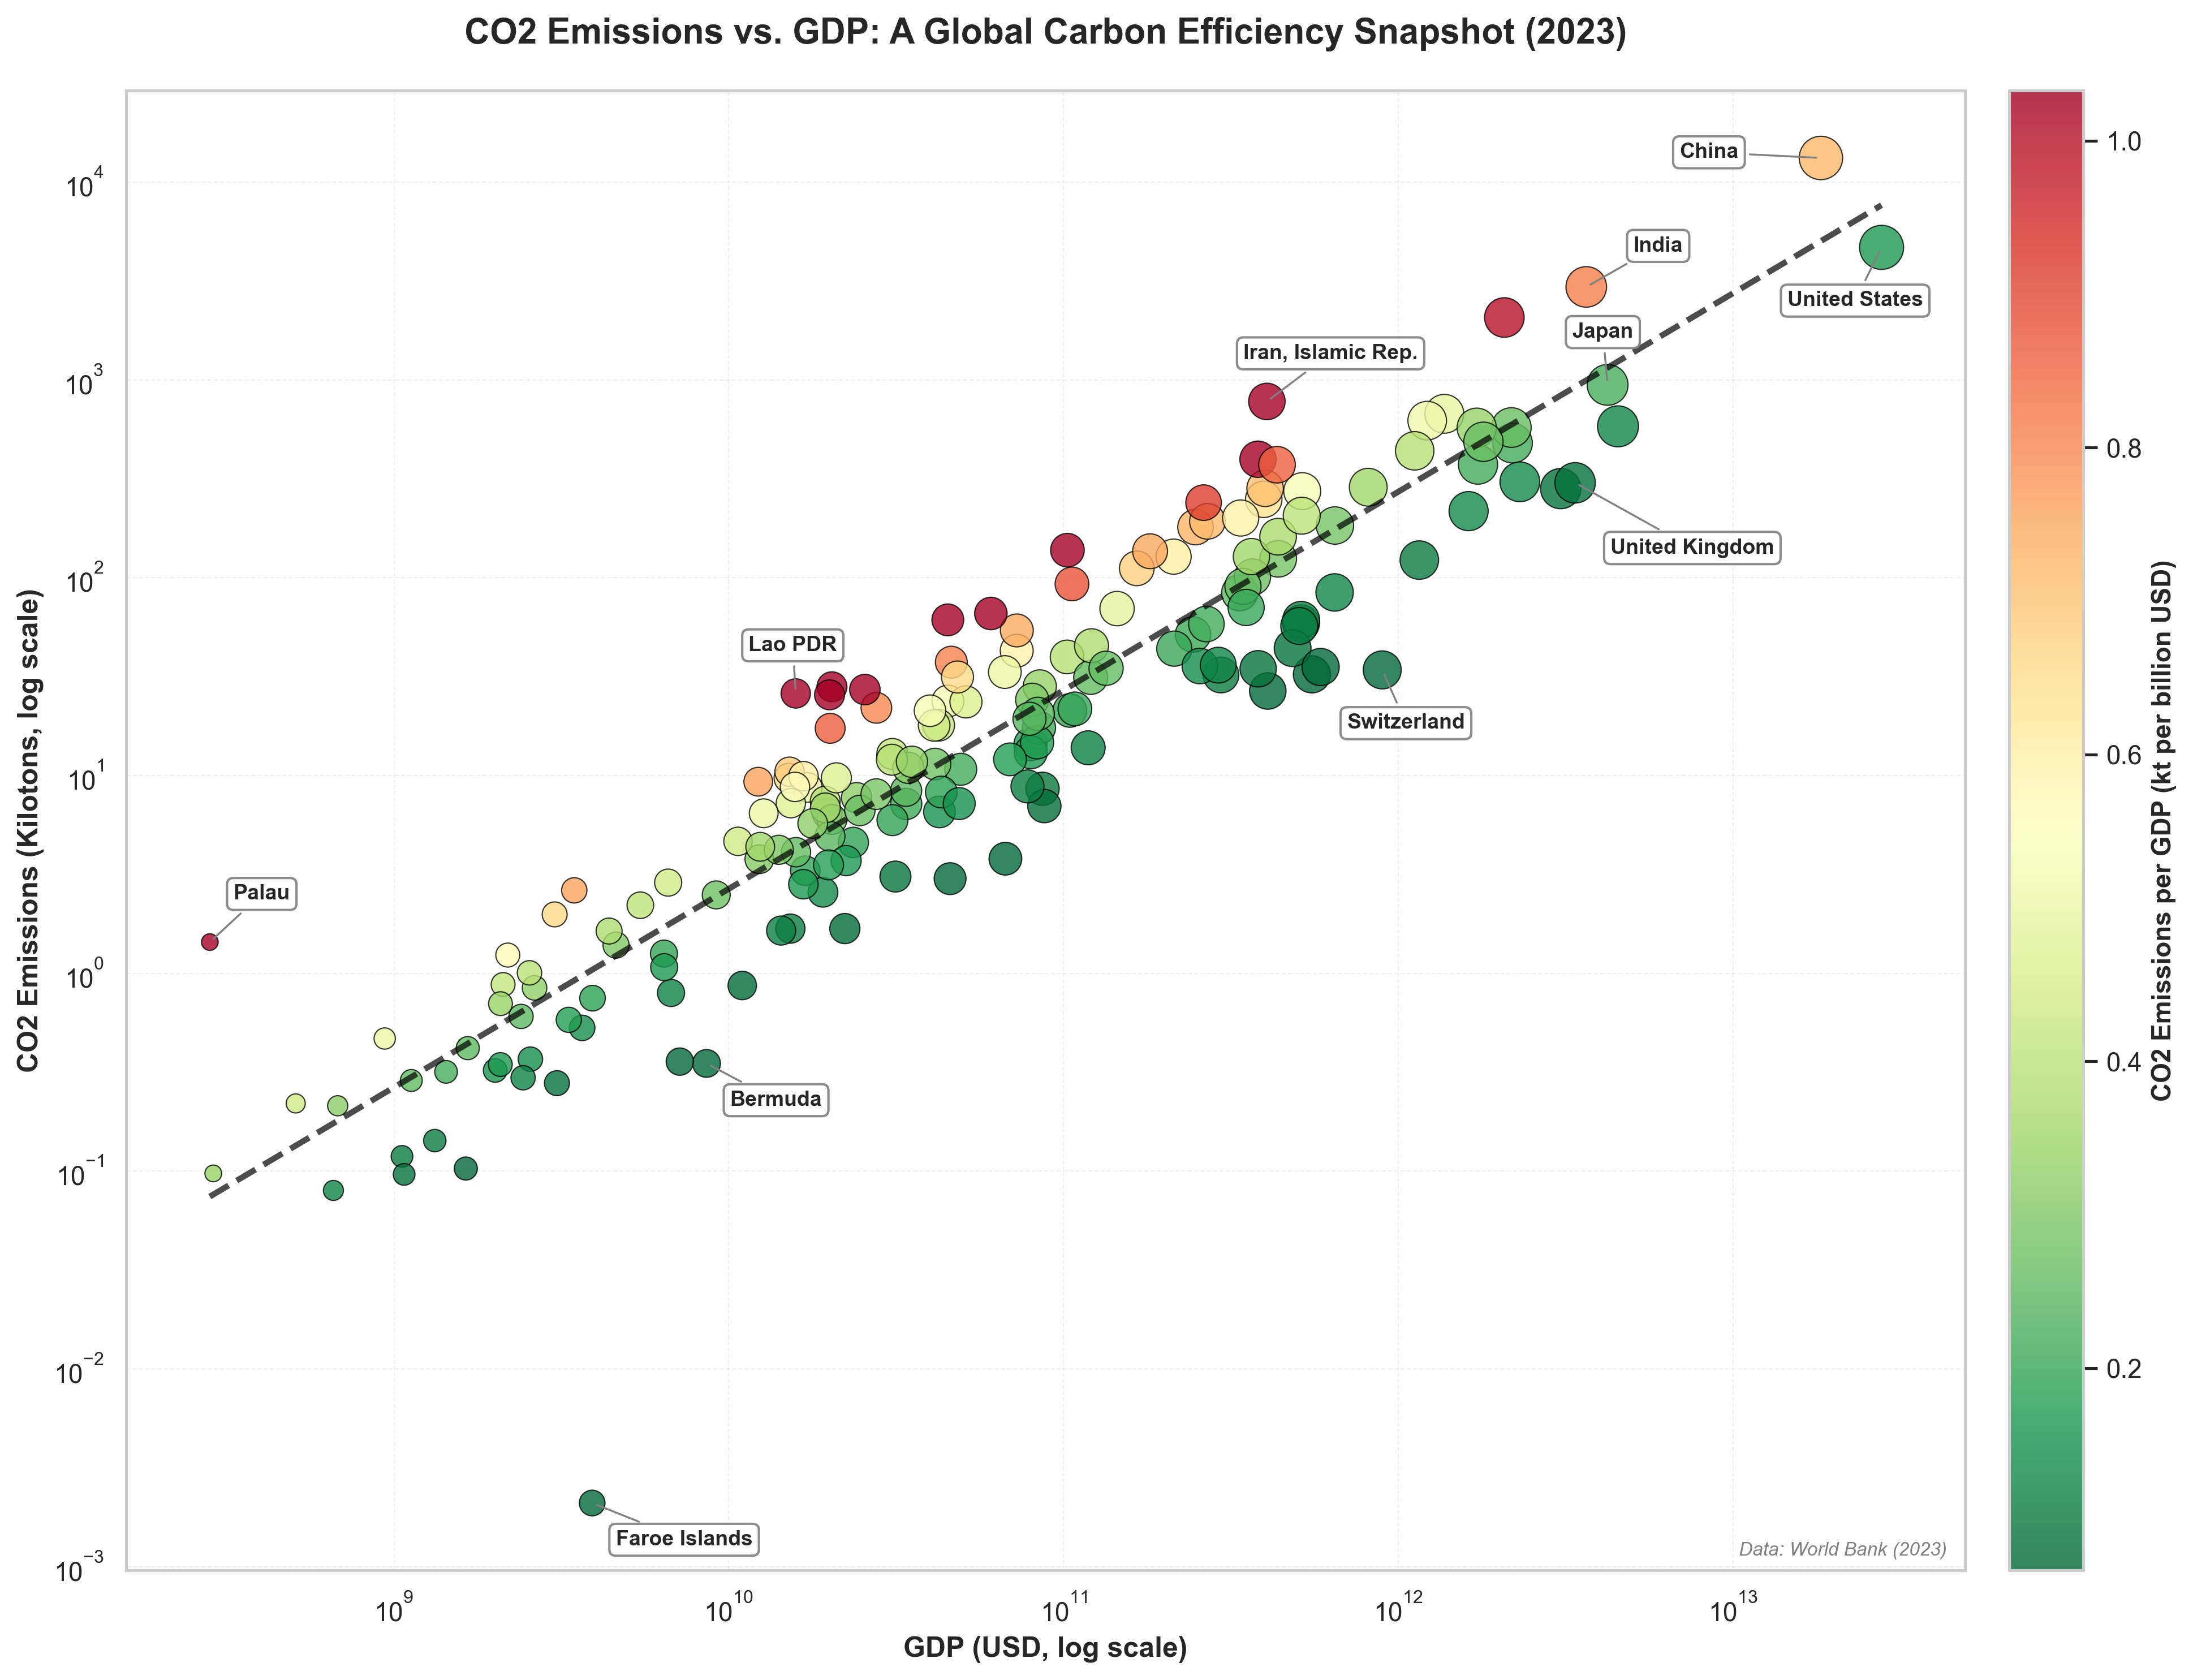

In [39]:
# VISUALIZATION 1: Economic Output vs. Carbon Footprint (2023)

# Filter data for 2023 and remove missing/invalid values
viz1_data = merged[merged['Year'] == 2023].copy()
viz1_data = viz1_data.dropna(subset=['GDP', 'CO2_emissions_kt'])
viz1_data = viz1_data[(viz1_data['GDP'] > 0) & (viz1_data['CO2_emissions_kt'] > 0)]

# Calculate carbon intensity: CO2 emissions (kt) per billion USD of GDP
# Lower values indicate more carbon-efficient economies
viz1_data['carbon_intensity'] = viz1_data['CO2_emissions_kt'] / (viz1_data['GDP'] / 1e9)

# Create normalized marker sizes based on GDP (log-scaled for better visualization)
viz1_data['log_gdp'] = np.log10(viz1_data['GDP'])
gdp_norm = (viz1_data['log_gdp'] - viz1_data['log_gdp'].min()) / \
           (viz1_data['log_gdp'].max() - viz1_data['log_gdp'].min())
viz1_data['marker_size'] = 50 + gdp_norm * 300

# Set color scale limits using percentiles to prevent outliers from dominating
vmin, vmax = np.percentile(viz1_data['carbon_intensity'], [5, 95])

# Compute regression line to show overall GDP-CO2 relationship
log_co2 = np.log10(viz1_data['CO2_emissions_kt'])
slope, intercept = stats.linregress(viz1_data['log_gdp'], log_co2)[:2]
gdp_range = np.logspace(np.log10(viz1_data['GDP'].min()), 
                        np.log10(viz1_data['GDP'].max()), 100)
co2_pred = 10 ** (intercept + slope * np.log10(gdp_range))

# Identify outliers: most and least carbon-efficient economies
most_efficient = viz1_data.nsmallest(3, 'carbon_intensity')
least_efficient = viz1_data.nlargest(3, 'carbon_intensity')

# Define major economies to highlight
key_countries = ['United States', 'China', 'India', 'Switzerland', 
                 'United Kingdom', 'Russia', 'Japan']

# Manual label positioning to avoid overlaps
positions = {
    'United States': (-40, -25), 'China': (-60, 0), 'India': (20, 15),
    'Switzerland': (-15, -25), 'United Kingdom': (15, -30),
    'Russia': (15, -25), 'Japan': (-15, 20)
}

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

# Main scatter plot: each point is a country
scatter = ax.scatter(
    viz1_data['GDP'], viz1_data['CO2_emissions_kt'],
    s=viz1_data['marker_size'],
    c=viz1_data['carbon_intensity'],
    cmap='RdYlGn_r',  # Red = high intensity, Green = low intensity
    vmin=vmin, vmax=vmax,
    alpha=0.8, edgecolors='black', linewidth=0.5
)

# Add regression line to show average GDP-CO2 relationship across all countries
ax.plot(gdp_range, co2_pred, '--', color='black', linewidth=2.5, alpha=0.7)

# Annotate major economies
for country in key_countries:
    country_data = viz1_data[viz1_data['Country Name'] == country]
    if not country_data.empty:
        row = country_data.iloc[0]
        dx, dy = positions.get(country, (0, 20))
        ax.annotate(
            country, xy=(row['GDP'], row['CO2_emissions_kt']),
            xytext=(dx, dy), textcoords='offset points',
            fontsize=9, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.9),
            arrowprops=dict(arrowstyle='-', color='gray', linewidth=0.8)
        )

# Annotate extreme outliers (least efficient)
for i, (_, row) in enumerate(least_efficient.iterrows()):
    if row['Country Name'] not in key_countries:
        dx, dy = 10 * ((-1) ** i), 18
        if row['Country Name'] == 'Mongolia': dx, dy = 0, 50
        if row['Country Name'] == 'Lao PDR': dx = -20
        ax.annotate(
            row['Country Name'], xy=(row['GDP'], row['CO2_emissions_kt']),
            xytext=(dx, dy), textcoords='offset points',
            fontsize=9, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.9),
            arrowprops=dict(arrowstyle='-', color='gray', linewidth=0.8)
        )

# Annotate extreme outliers (most efficient)
for i, (_, row) in enumerate(most_efficient.iterrows()):
    if row['Country Name'] not in key_countries:
        dx, dy = 10 * ((-1) ** i), -18
        if row['Country Name'] == 'Cayman Islands': dx, dy = -50, -50
        ax.annotate(
            row['Country Name'], xy=(row['GDP'], row['CO2_emissions_kt']),
            xytext=(dx, dy), textcoords='offset points',
            fontsize=9, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.9),
            arrowprops=dict(arrowstyle='-', color='gray', linewidth=0.8)
        )

# Format axes and styling
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('GDP (USD, log scale)', fontsize=12, fontweight='bold')
ax.set_ylabel('CO2 Emissions (Kilotons, log scale)', fontsize=12, fontweight='bold')
ax.set_title('CO2 Emissions vs. GDP: A Global Carbon Efficiency Snapshot (2023)',
             fontsize=15, fontweight='bold', pad=20)

# Add colorbar legend
cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('CO2 Emissions per GDP (kt per billion USD)', 
               fontsize=11, fontweight='bold')

# Add grid and data source
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.text(0.99, 0.01, 'Data: World Bank (2023)', transform=ax.transAxes,
        fontsize=8, ha='right', style='italic', color='gray')

plt.tight_layout()
plt.show()

## Vizualisation 2

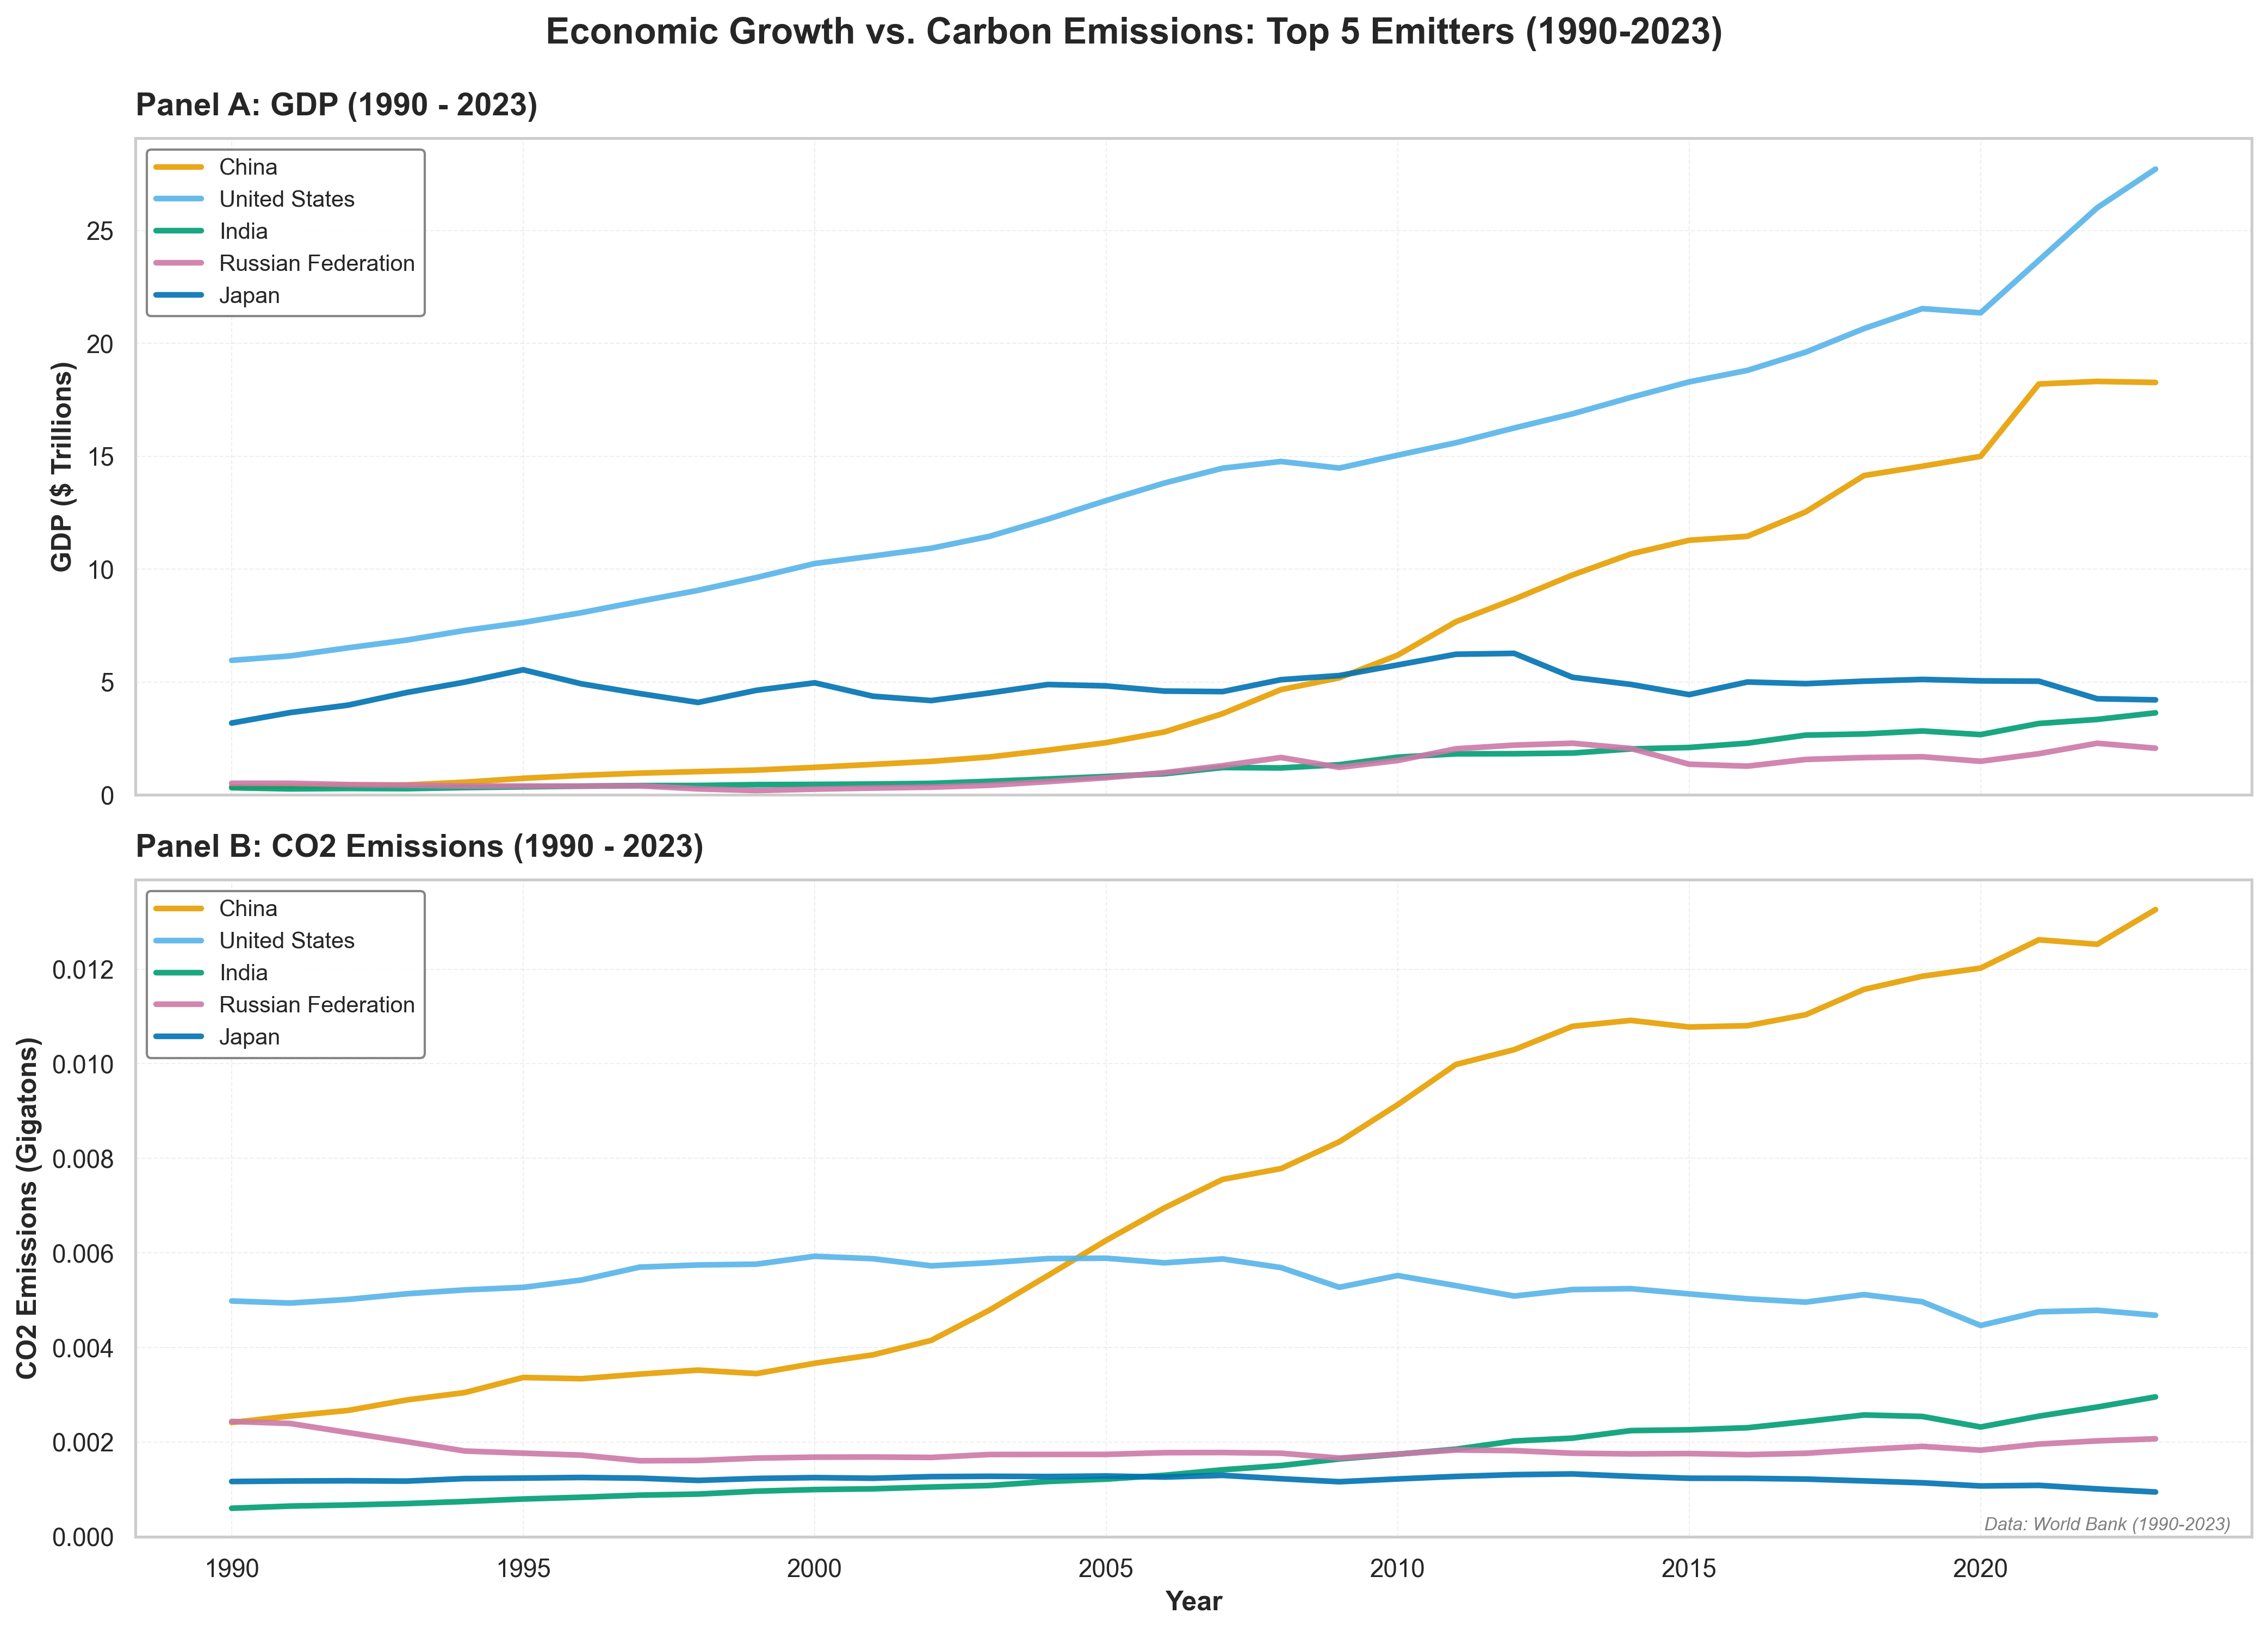

In [40]:
# VISUALIZATION 2: GDP and CO2 Trends for Top Emitters (1990-2023)

# Identify the top 5 CO2 emitters in 2023
top_emitters = (
    merged[merged['Year'] == 2023]
    .nlargest(5, 'CO2_emissions_kt')['Country Name']
    .tolist()
)

# Filter data for top emitters from 1990 onwards (modern era of climate awareness)
viz2_data = merged[
    (merged['Country Name'].isin(top_emitters)) & 
    (merged['Year'] >= 1990) & 
    (merged['Year'] <= 2023)
].copy()

# Define a professional color palette inspired by your VIZ 1
# Using distinct, colorblind-friendly colors for clarity
country_colors = {
    'China': '#E69F00',           # Orange - largest emitter
    'United States': '#56B4E9',   # Sky blue
    'India': '#009E73',           # Green - rapidly growing
    'Russian Federation': '#CC79A7',  # Pink/purple
    'Japan': '#0072B2'            # Dark blue - developed economy
}

# Create dual-panel figure with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Panel A: GDP trends showing economic growth trajectories
for country in top_emitters:
    country_data = viz2_data[viz2_data['Country Name'] == country].sort_values('Year')
    ax1.plot(
        country_data['Year'],
        country_data['GDP'] / 1e12,  # Convert to trillions for readability
        linewidth=2.5,
        color=country_colors.get(country, '#999999'),
        label=country,
        alpha=0.9
    )

ax1.set_ylabel('GDP ($ Trillions)', fontsize=12, fontweight='bold')
ax1.set_title('Panel A: GDP (1990 - 2023)', fontsize=14, fontweight='bold', loc='left', pad=10)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax1.legend(loc='upper left', fontsize=10, framealpha=0.95, edgecolor='gray')
ax1.set_ylim(bottom=0)  # Start y-axis at zero for accurate visual comparison

# Panel B: CO2 emissions showing environmental impact trajectories
for country in top_emitters:
    country_data = viz2_data[viz2_data['Country Name'] == country].sort_values('Year')
    ax2.plot(
        country_data['Year'],
        country_data['CO2_emissions_kt'] / 1e6,  # Convert to gigatons
        linewidth=2.5,
        color=country_colors.get(country, '#999999'),
        label=country,
        alpha=0.9
    )

ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('CO2 Emissions (Gigatons)', fontsize=12, fontweight='bold')
ax2.set_title('Panel B: CO2 Emissions (1990 - 2023)', fontsize=14, fontweight='bold', loc='left', pad=10)
ax2.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax2.legend(loc='upper left', fontsize=10, framealpha=0.95, edgecolor='gray')
ax2.set_ylim(bottom=0)  # Start y-axis at zero for accurate visual comparison

# Overall title highlighting the key question
fig.suptitle('Economic Growth vs. Carbon Emissions: Top 5 Emitters (1990-2023)',
             fontsize=16, fontweight='bold', y=0.995)

# Data source citation
ax2.text(0.99, 0.01, 'Data: World Bank (1990-2023)', transform=ax2.transAxes,
         fontsize=8, ha='right', style='italic', color='gray')

plt.tight_layout()
plt.show()

## Visualization 3

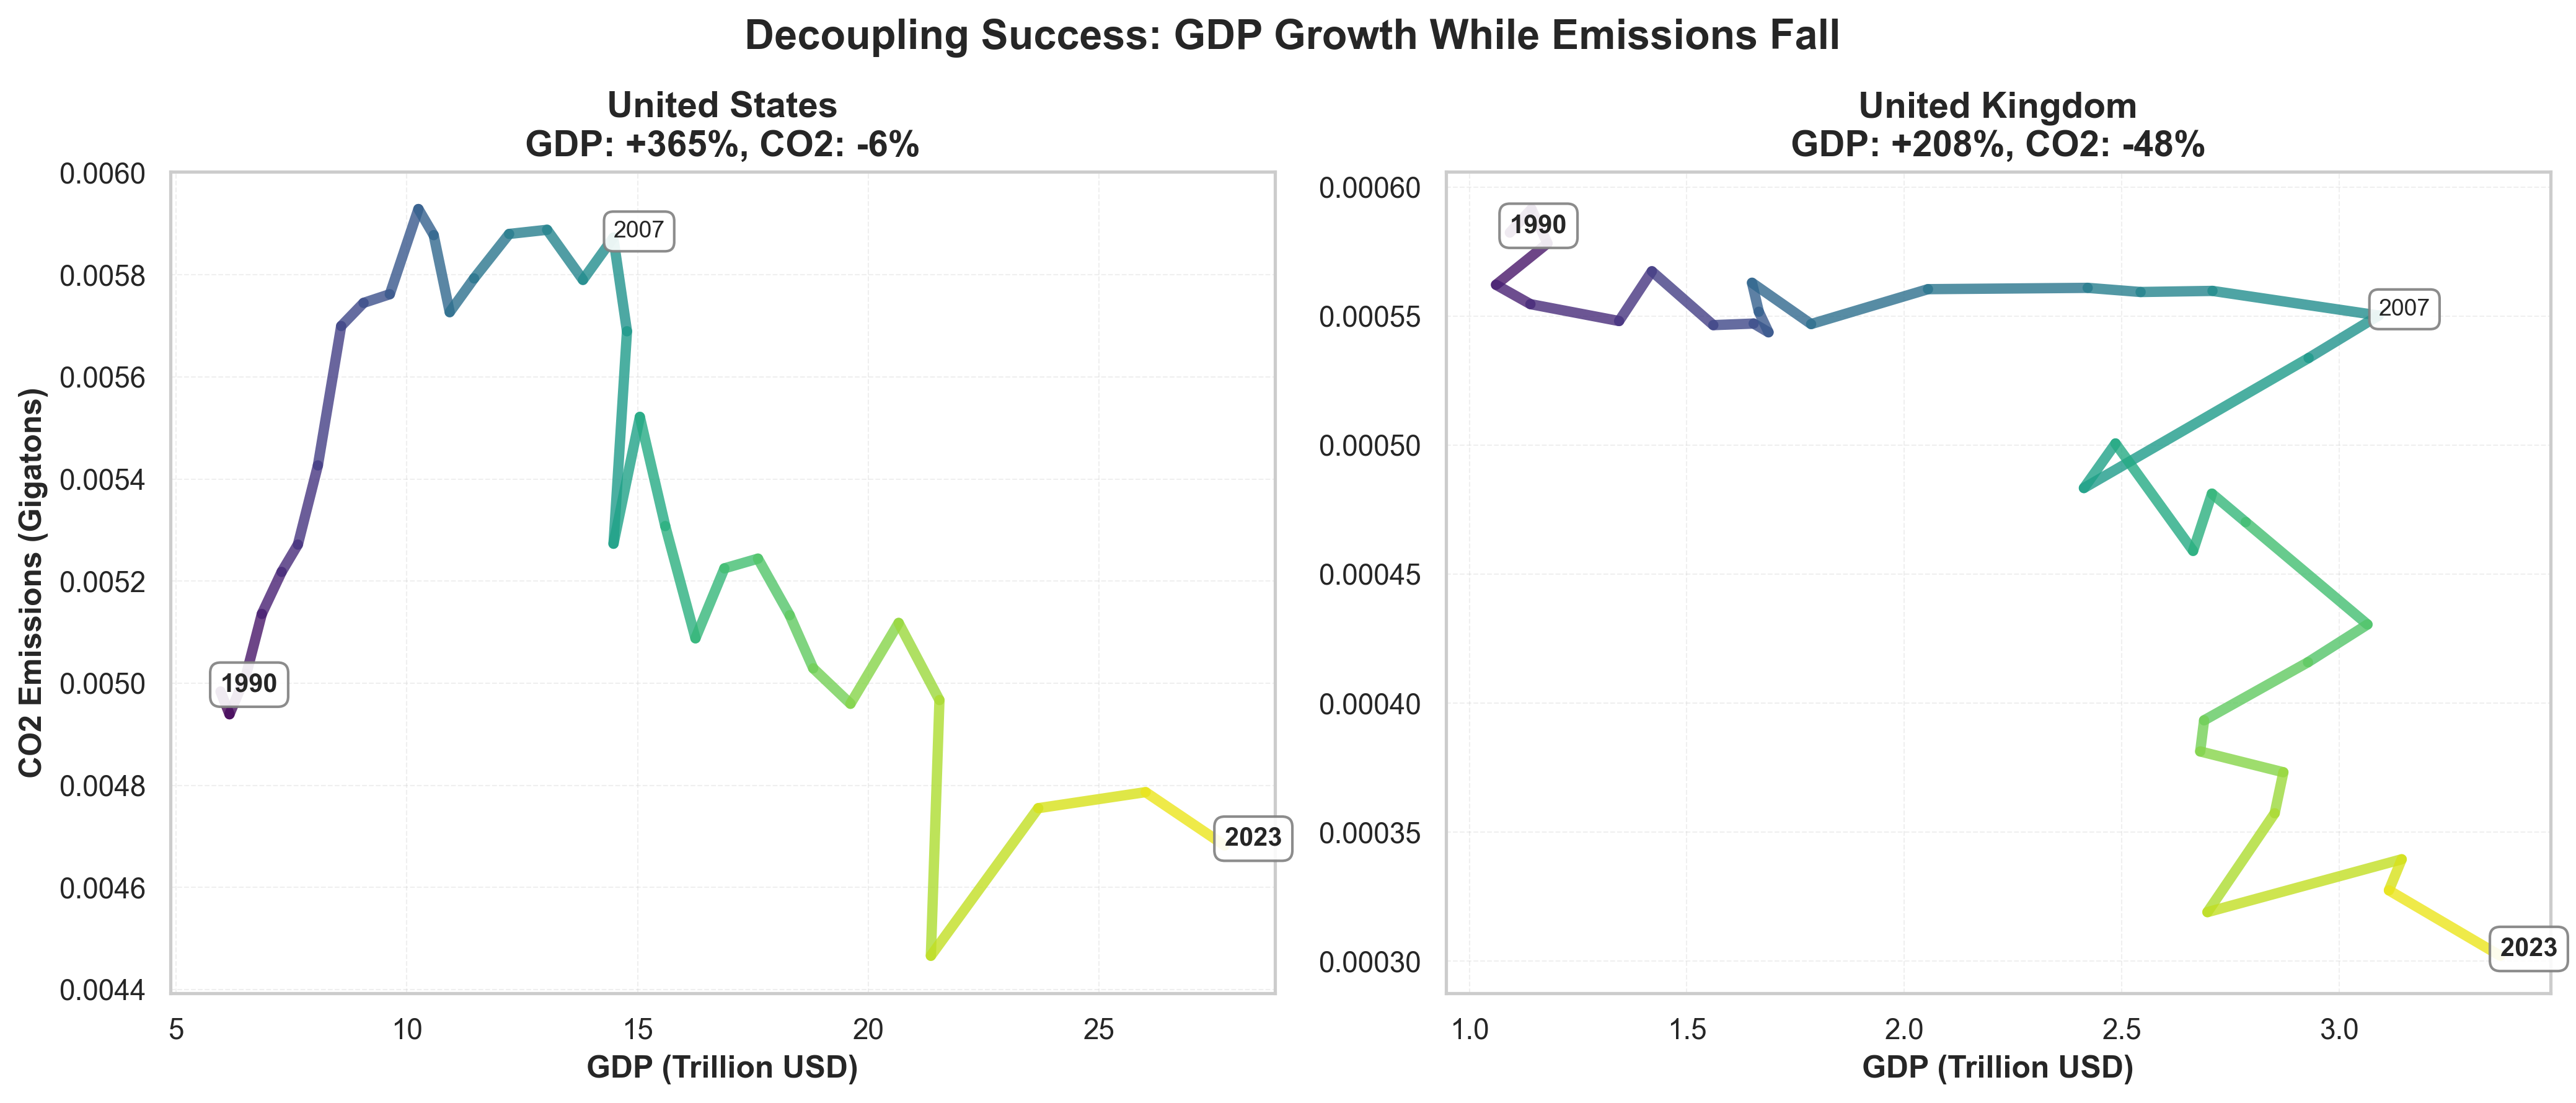

In [41]:
# VISUALIZATION 3a: Decoupling Success Stories (1990-2023)

# Select two exemplary decoupling success stories
winners = ['United States', 'United Kingdom']

# Filter data for winners from 1990-2023
viz3_data = merged[
    (merged['Country Name'].isin(winners)) & 
    (merged['Year'] >= 1990) & 
    (merged['Year'] <= 2023)
].copy()

# Create side-by-side comparison plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Decoupling Success: GDP Growth While Emissions Fall',
             fontsize=16, fontweight='bold')

for idx, country in enumerate(winners):
    ax = axes[idx]
    country_data = viz3_data[viz3_data['Country Name'] == country].sort_values('Year')
    
    # Extract and convert units for readability
    years = country_data['Year'].values
    gdp = country_data['GDP'].values / 1e12      # Convert to trillions
    co2 = country_data['CO2_emissions_kt'].values / 1e6  # Convert to gigatons
    
    # Plot trajectory with color gradient showing time progression
    # Earlier years (1990s) appear purple/blue, later years (2020s) appear yellow
    for i in range(len(years) - 1):
        color_intensity = (years[i] - 1990) / 33  # Normalize to 0-1 range
        ax.plot(gdp[i:i+2], co2[i:i+2], 
               color=plt.cm.viridis(color_intensity),
               linewidth=4, alpha=0.8)
    
    # Label key time points: start, middle, and end
    label_style = dict(boxstyle='round,pad=0.4', facecolor='white', 
                      edgecolor='gray', alpha=0.9)
    
    ax.text(gdp[0], co2[0], '1990', fontsize=10, fontweight='bold', bbox=label_style)
    mid_idx = len(years) // 2
    ax.text(gdp[mid_idx], co2[mid_idx], f'{int(years[mid_idx])}', 
           fontsize=9, bbox=label_style)
    ax.text(gdp[-1], co2[-1], '2023', fontsize=10, fontweight='bold', bbox=label_style)
    
    # Calculate percent changes to quantify decoupling success
    gdp_change = ((gdp[-1] / gdp[0]) - 1) * 100
    co2_change = ((co2[-1] / co2[0]) - 1) * 100
    
    # Format plot
    ax.set_title(f'{country}\nGDP: +{gdp_change:.0f}%, CO2: {co2_change:.0f}%',
                fontsize=14, fontweight='bold')
    ax.set_xlabel('GDP (Trillion USD)', fontsize=12, fontweight='bold')
    if idx == 0:  # Only show y-label on left panel
        ax.set_ylabel('CO2 Emissions (Gigatons)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

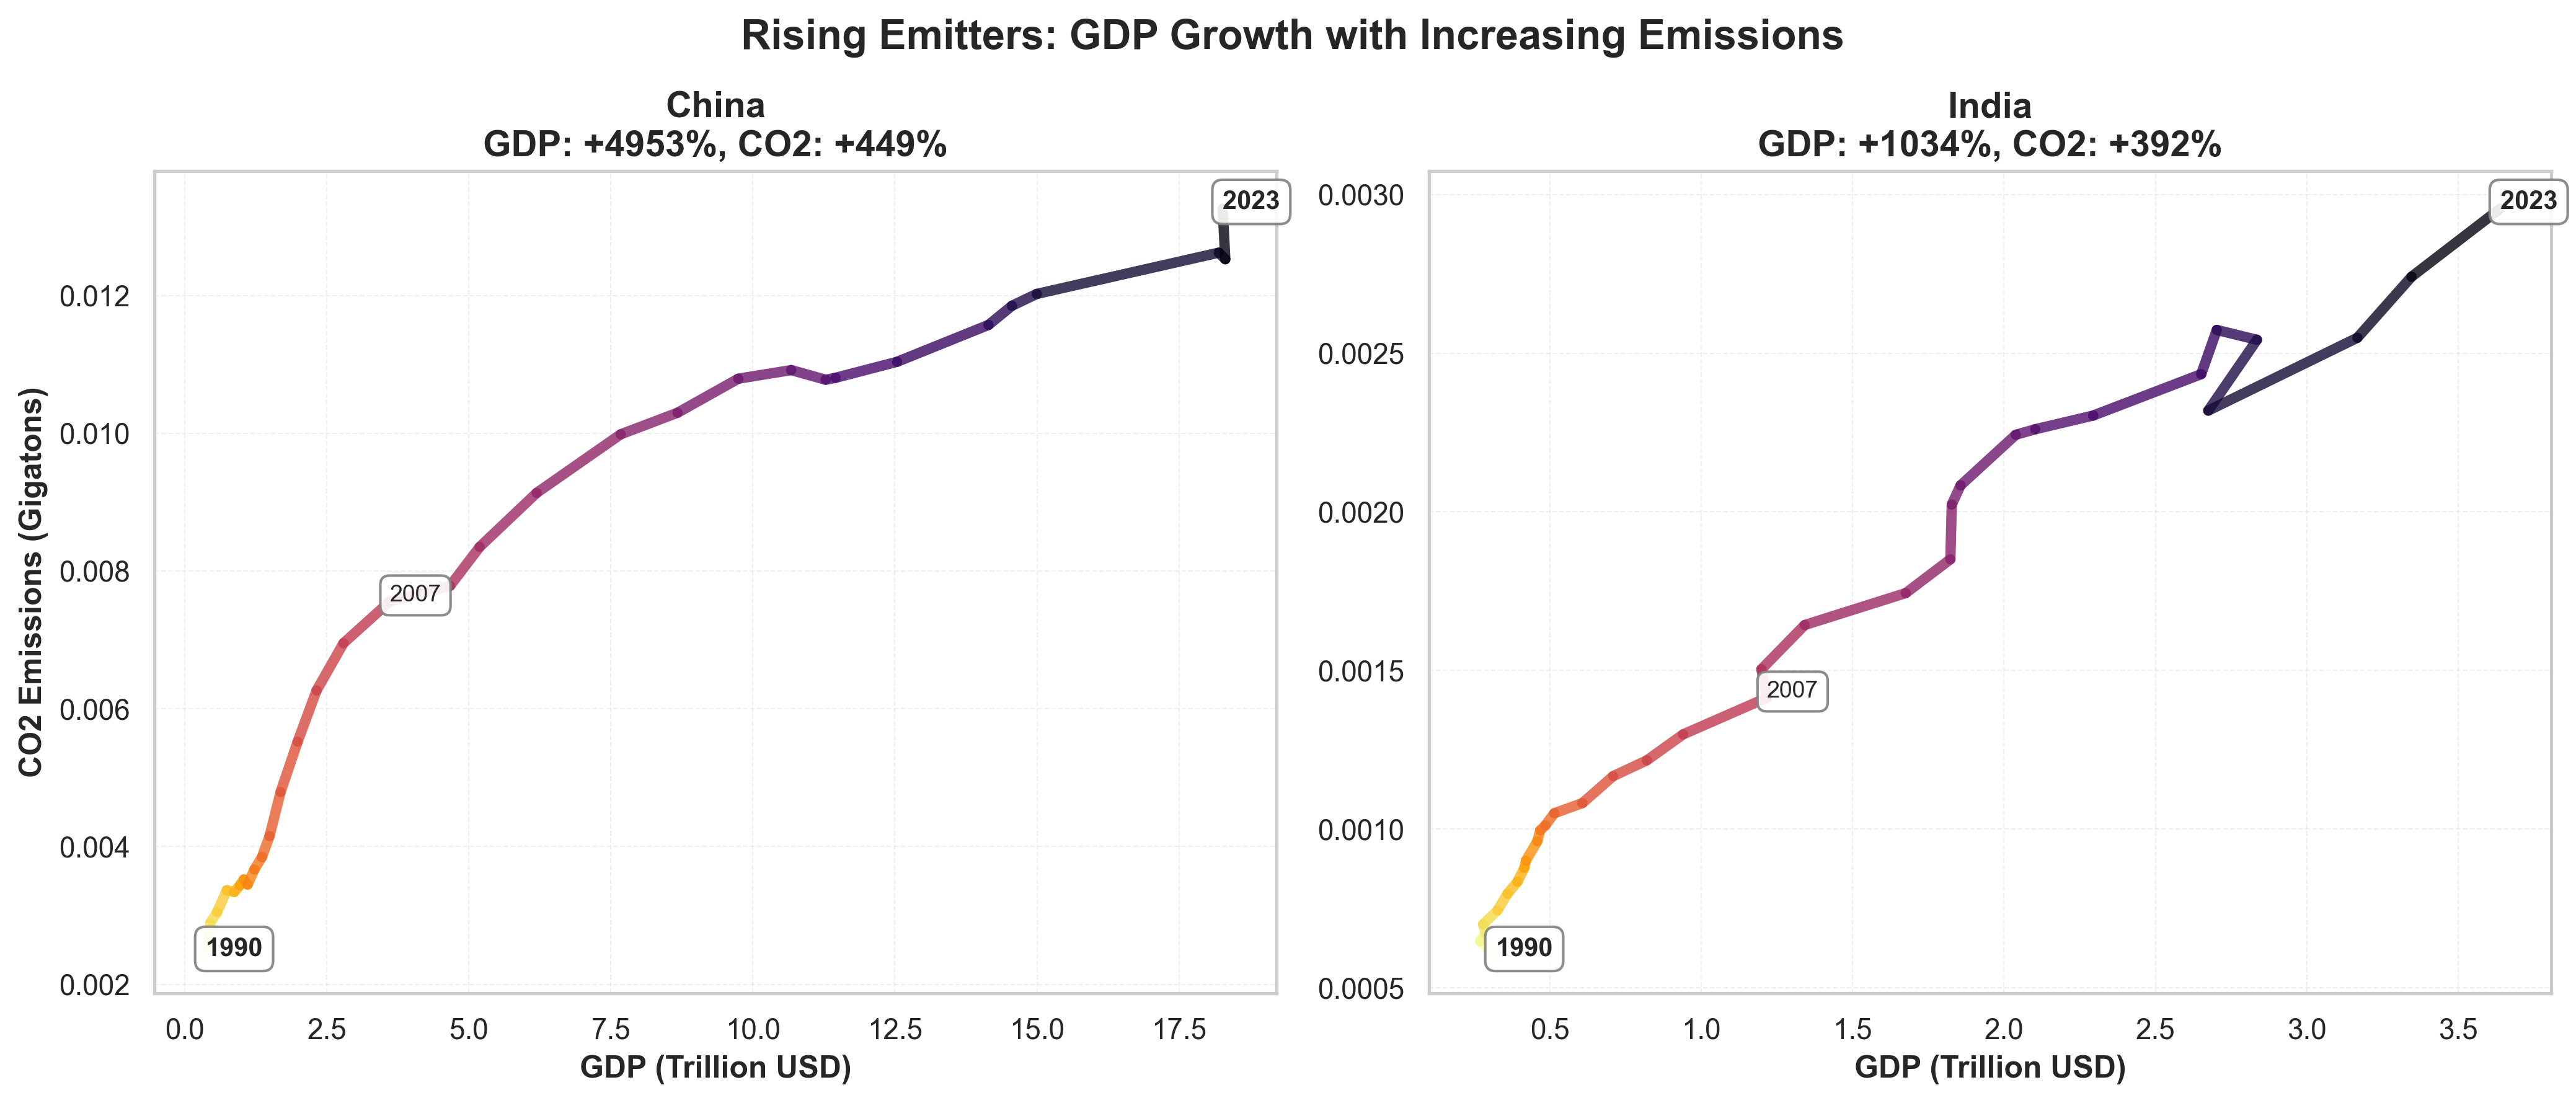

In [42]:
# VISUALIZATION 3b: Rising Emitters - Growth Still Tied to Carbon (1990-2023)

# Select two countries with strong GDP-CO2 coupling
coupled_countries = ['China', 'India']

# Filter data for these countries from 1990-2023
viz3b_data = merged[
    (merged['Country Name'].isin(coupled_countries)) & 
    (merged['Year'] >= 1990) & 
    (merged['Year'] <= 2023)
].copy()

# Create side-by-side comparison plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Rising Emitters: GDP Growth with Increasing Emissions',
             fontsize=16, fontweight='bold')

for idx, country in enumerate(coupled_countries):
    ax = axes[idx]
    country_data = viz3b_data[viz3b_data['Country Name'] == country].sort_values('Year')
    
    # Extract and convert units for readability
    years = country_data['Year'].values
    gdp = country_data['GDP'].values / 1e12      # Convert to trillions
    co2 = country_data['CO2_emissions_kt'].values / 1e6  # Convert to gigatons
    
    # Plot trajectory with color gradient showing time progression
    # Using inferno_r colormap: earlier years are lighter, later years are darker/redder
    for i in range(len(years) - 1):
        color_intensity = (years[i] - 1990) / 33  # Normalize to 0-1 range
        ax.plot(gdp[i:i+2], co2[i:i+2], 
               color=plt.cm.inferno_r(color_intensity),
               linewidth=4, alpha=0.8)
    
    # Label key time points: start, middle, and end
    label_style = dict(boxstyle='round,pad=0.4', facecolor='white', 
                      edgecolor='gray', alpha=0.9)
    
    ax.text(gdp[0], co2[0], '1990', fontsize=10, fontweight='bold', bbox=label_style)
    mid_idx = len(years) // 2
    ax.text(gdp[mid_idx], co2[mid_idx], f'{int(years[mid_idx])}', 
           fontsize=9, bbox=label_style)
    ax.text(gdp[-1], co2[-1], '2023', fontsize=10, fontweight='bold', bbox=label_style)
    
    # Calculate percent changes to quantify coupling
    gdp_change = ((gdp[-1] / gdp[0]) - 1) * 100
    co2_change = ((co2[-1] / co2[0]) - 1) * 100
    
    # Format plot
    ax.set_title(f'{country}\nGDP: +{gdp_change:.0f}%, CO2: +{co2_change:.0f}%',
                fontsize=14, fontweight='bold')
    ax.set_xlabel('GDP (Trillion USD)', fontsize=12, fontweight='bold')
    if idx == 0:  # Only show y-label on left panel
        ax.set_ylabel('CO2 Emissions (Gigatons)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## Visualization 4

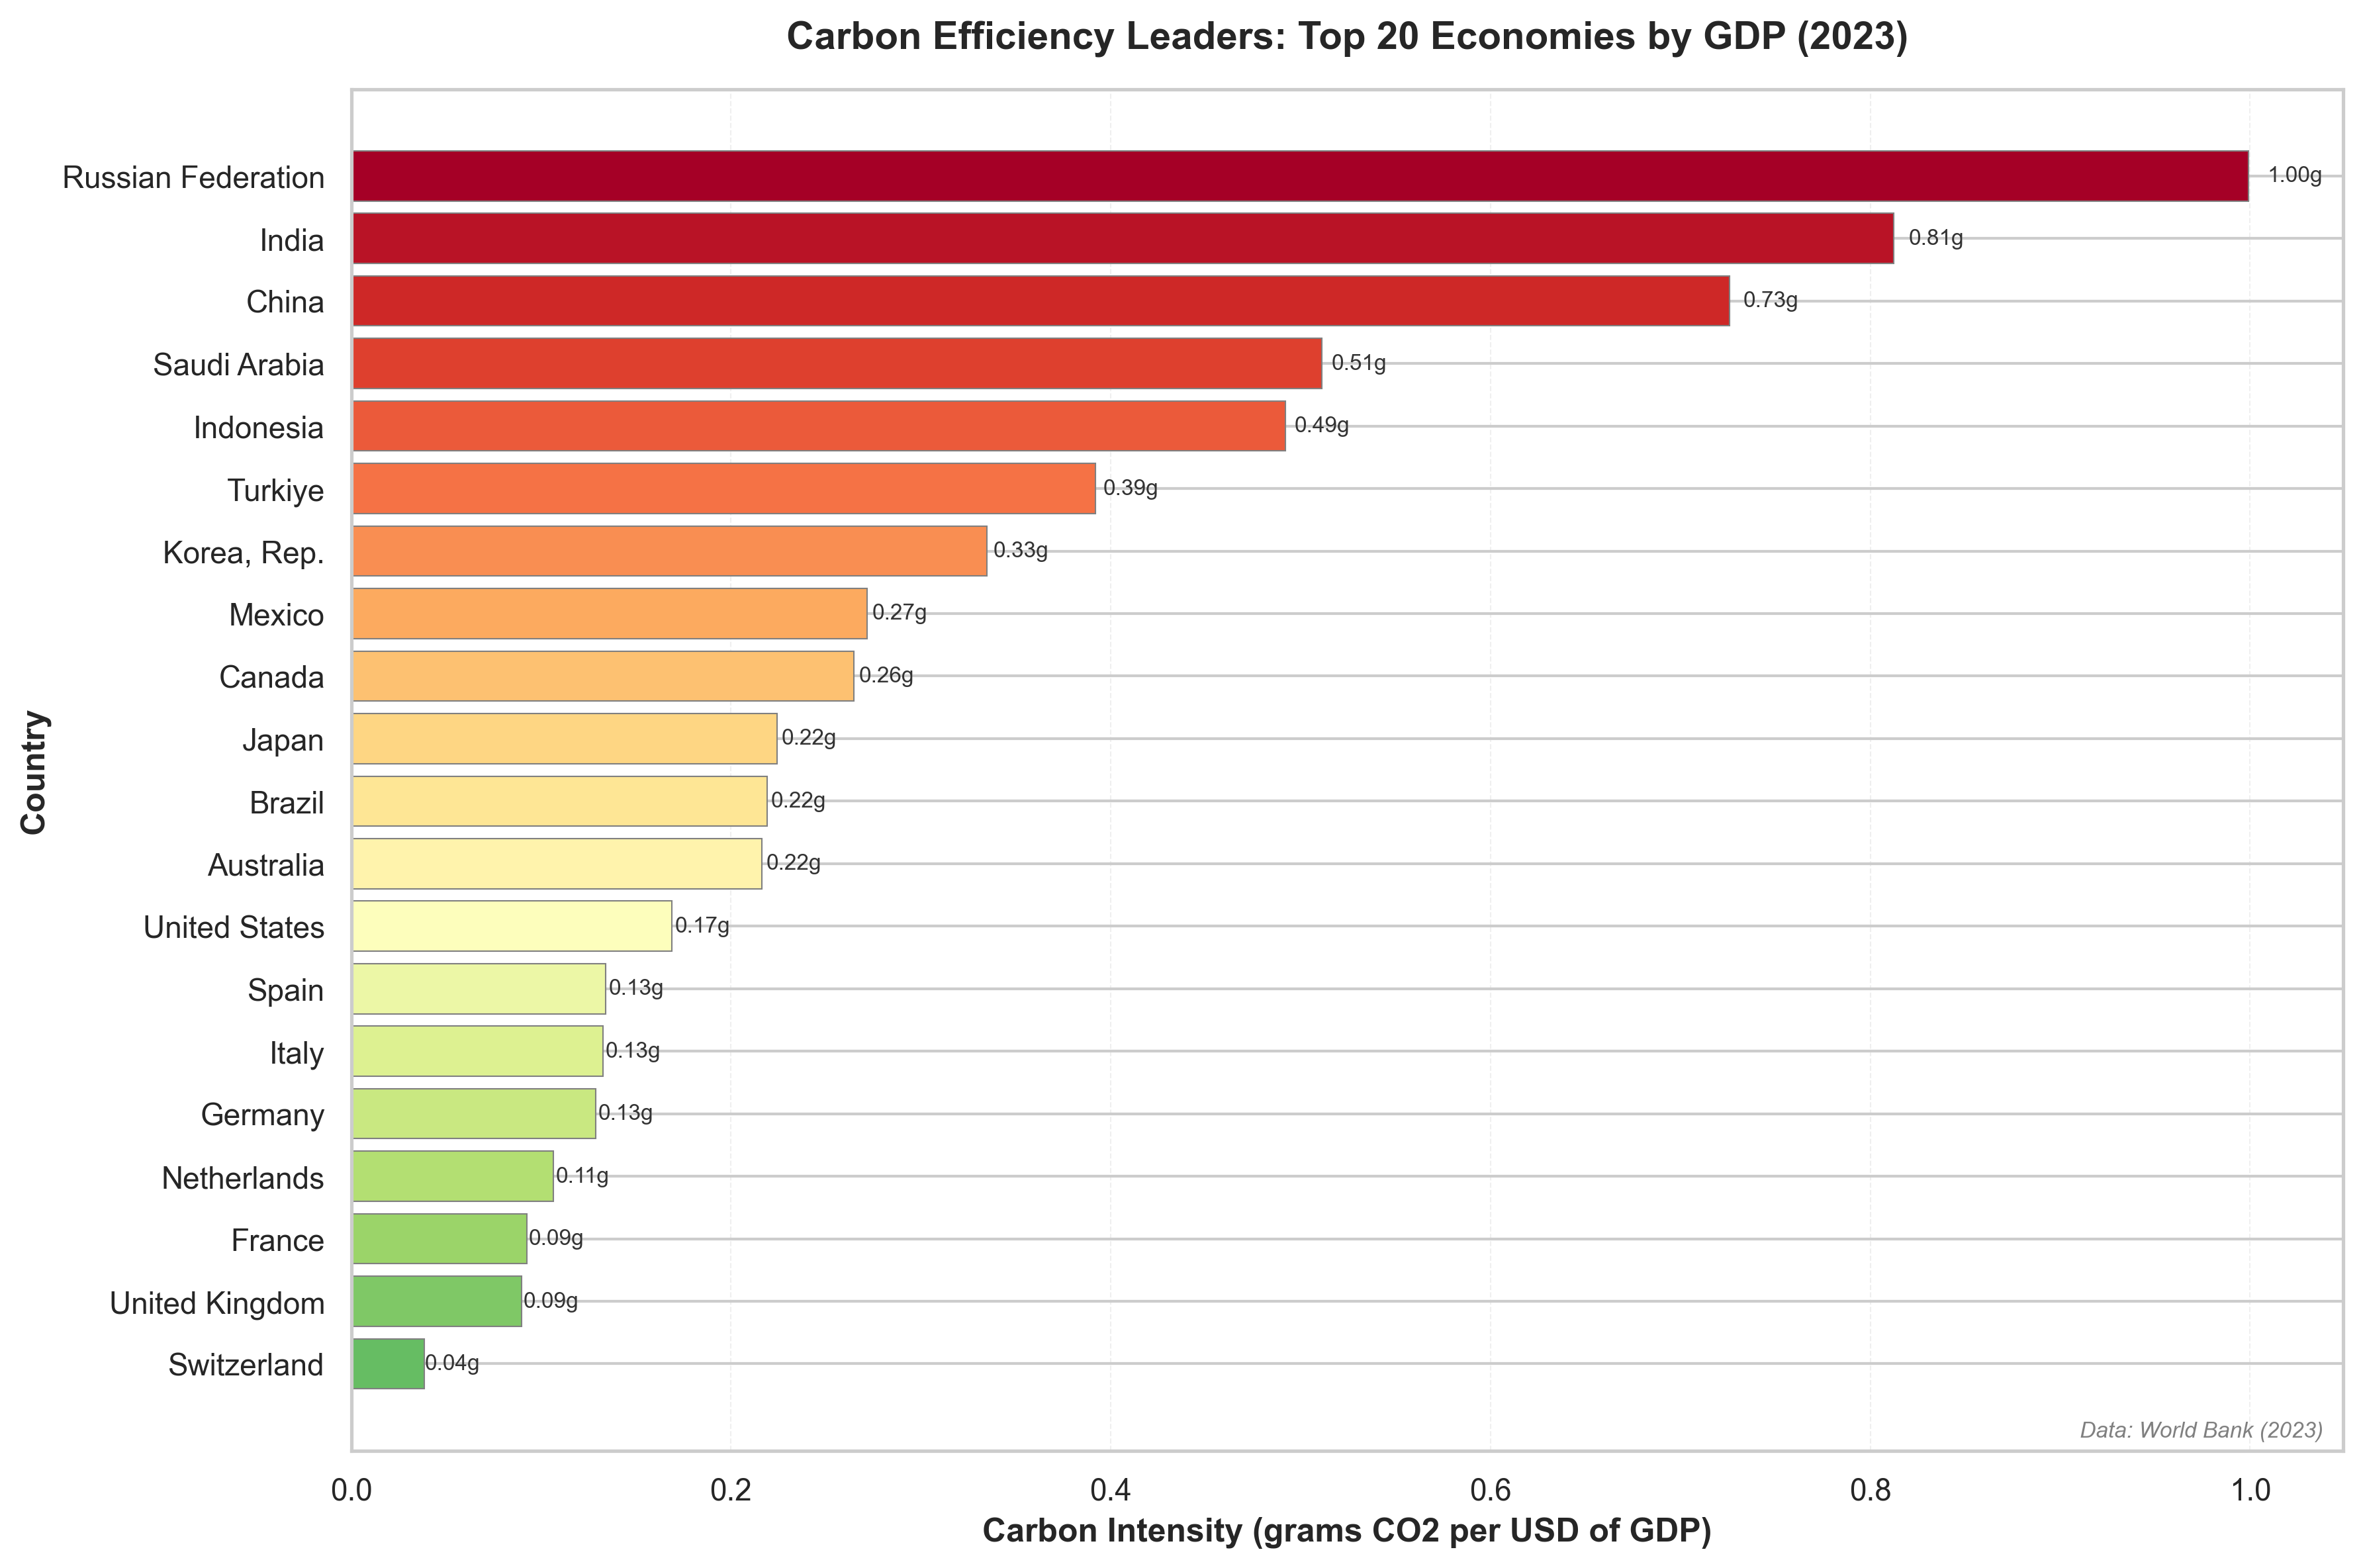

In [ ]:
# VISUALIZATION 4: Carbon Intensity Rankings - Top 20 Economies (2023)


# Filter data for 2023 with valid carbon intensity values
viz4_data = merged[merged['Year'] == 2023].copy()
viz4_data = viz4_data.dropna(subset=['Carbon_intensity'])

# Remove extreme outliers (caused by data quality issues or very small economies)
viz4_data = viz4_data[np.isfinite(viz4_data['Carbon_intensity'])]
viz4_data = viz4_data[viz4_data['Carbon_intensity'] < 5]

# Select top 20 economies by GDP and sort by carbon intensity (most efficient first)
top20 = (
    viz4_data.nlargest(20, 'GDP')
    .sort_values('Carbon_intensity', ascending=True)
)

# Convert intensity to grams per USD for easier interpretation
top20['Carbon_intensity_g'] = top20['Carbon_intensity'] * 1e6

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Create color gradient from green (efficient) to red (inefficient)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 1, len(top20)))

bars = ax.barh(
    top20['Country Name'],
    top20['Carbon_intensity_g'],
    color=colors,
    edgecolor='gray',
    linewidth=0.5
)

# Format plot
ax.set_xlabel('Carbon Intensity (grams CO2 per USD of GDP)', fontsize=12, fontweight='bold')
ax.set_ylabel('Country', fontsize=12, fontweight='bold')
ax.set_title('Carbon Efficiency Leaders: Top 20 Economies by GDP (2023)', 
             fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)

# Add value labels to the end of each bar
for bar, val in zip(bars, top20['Carbon_intensity_g']):
    ax.text(
        val * 1.01,
        bar.get_y() + bar.get_height() / 2,
        f'{val:.2f}g',
        va='center',
        fontsize=8,
        color='#333333'
    )

# Format x-axis with one decimal place
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))

# Add data source
ax.text(0.99, 0.01, 'Data: World Bank (2023)', transform=ax.transAxes,
        fontsize=8, ha='right', style='italic', color='gray')

plt.tight_layout()
plt.show()

## Visualization 5

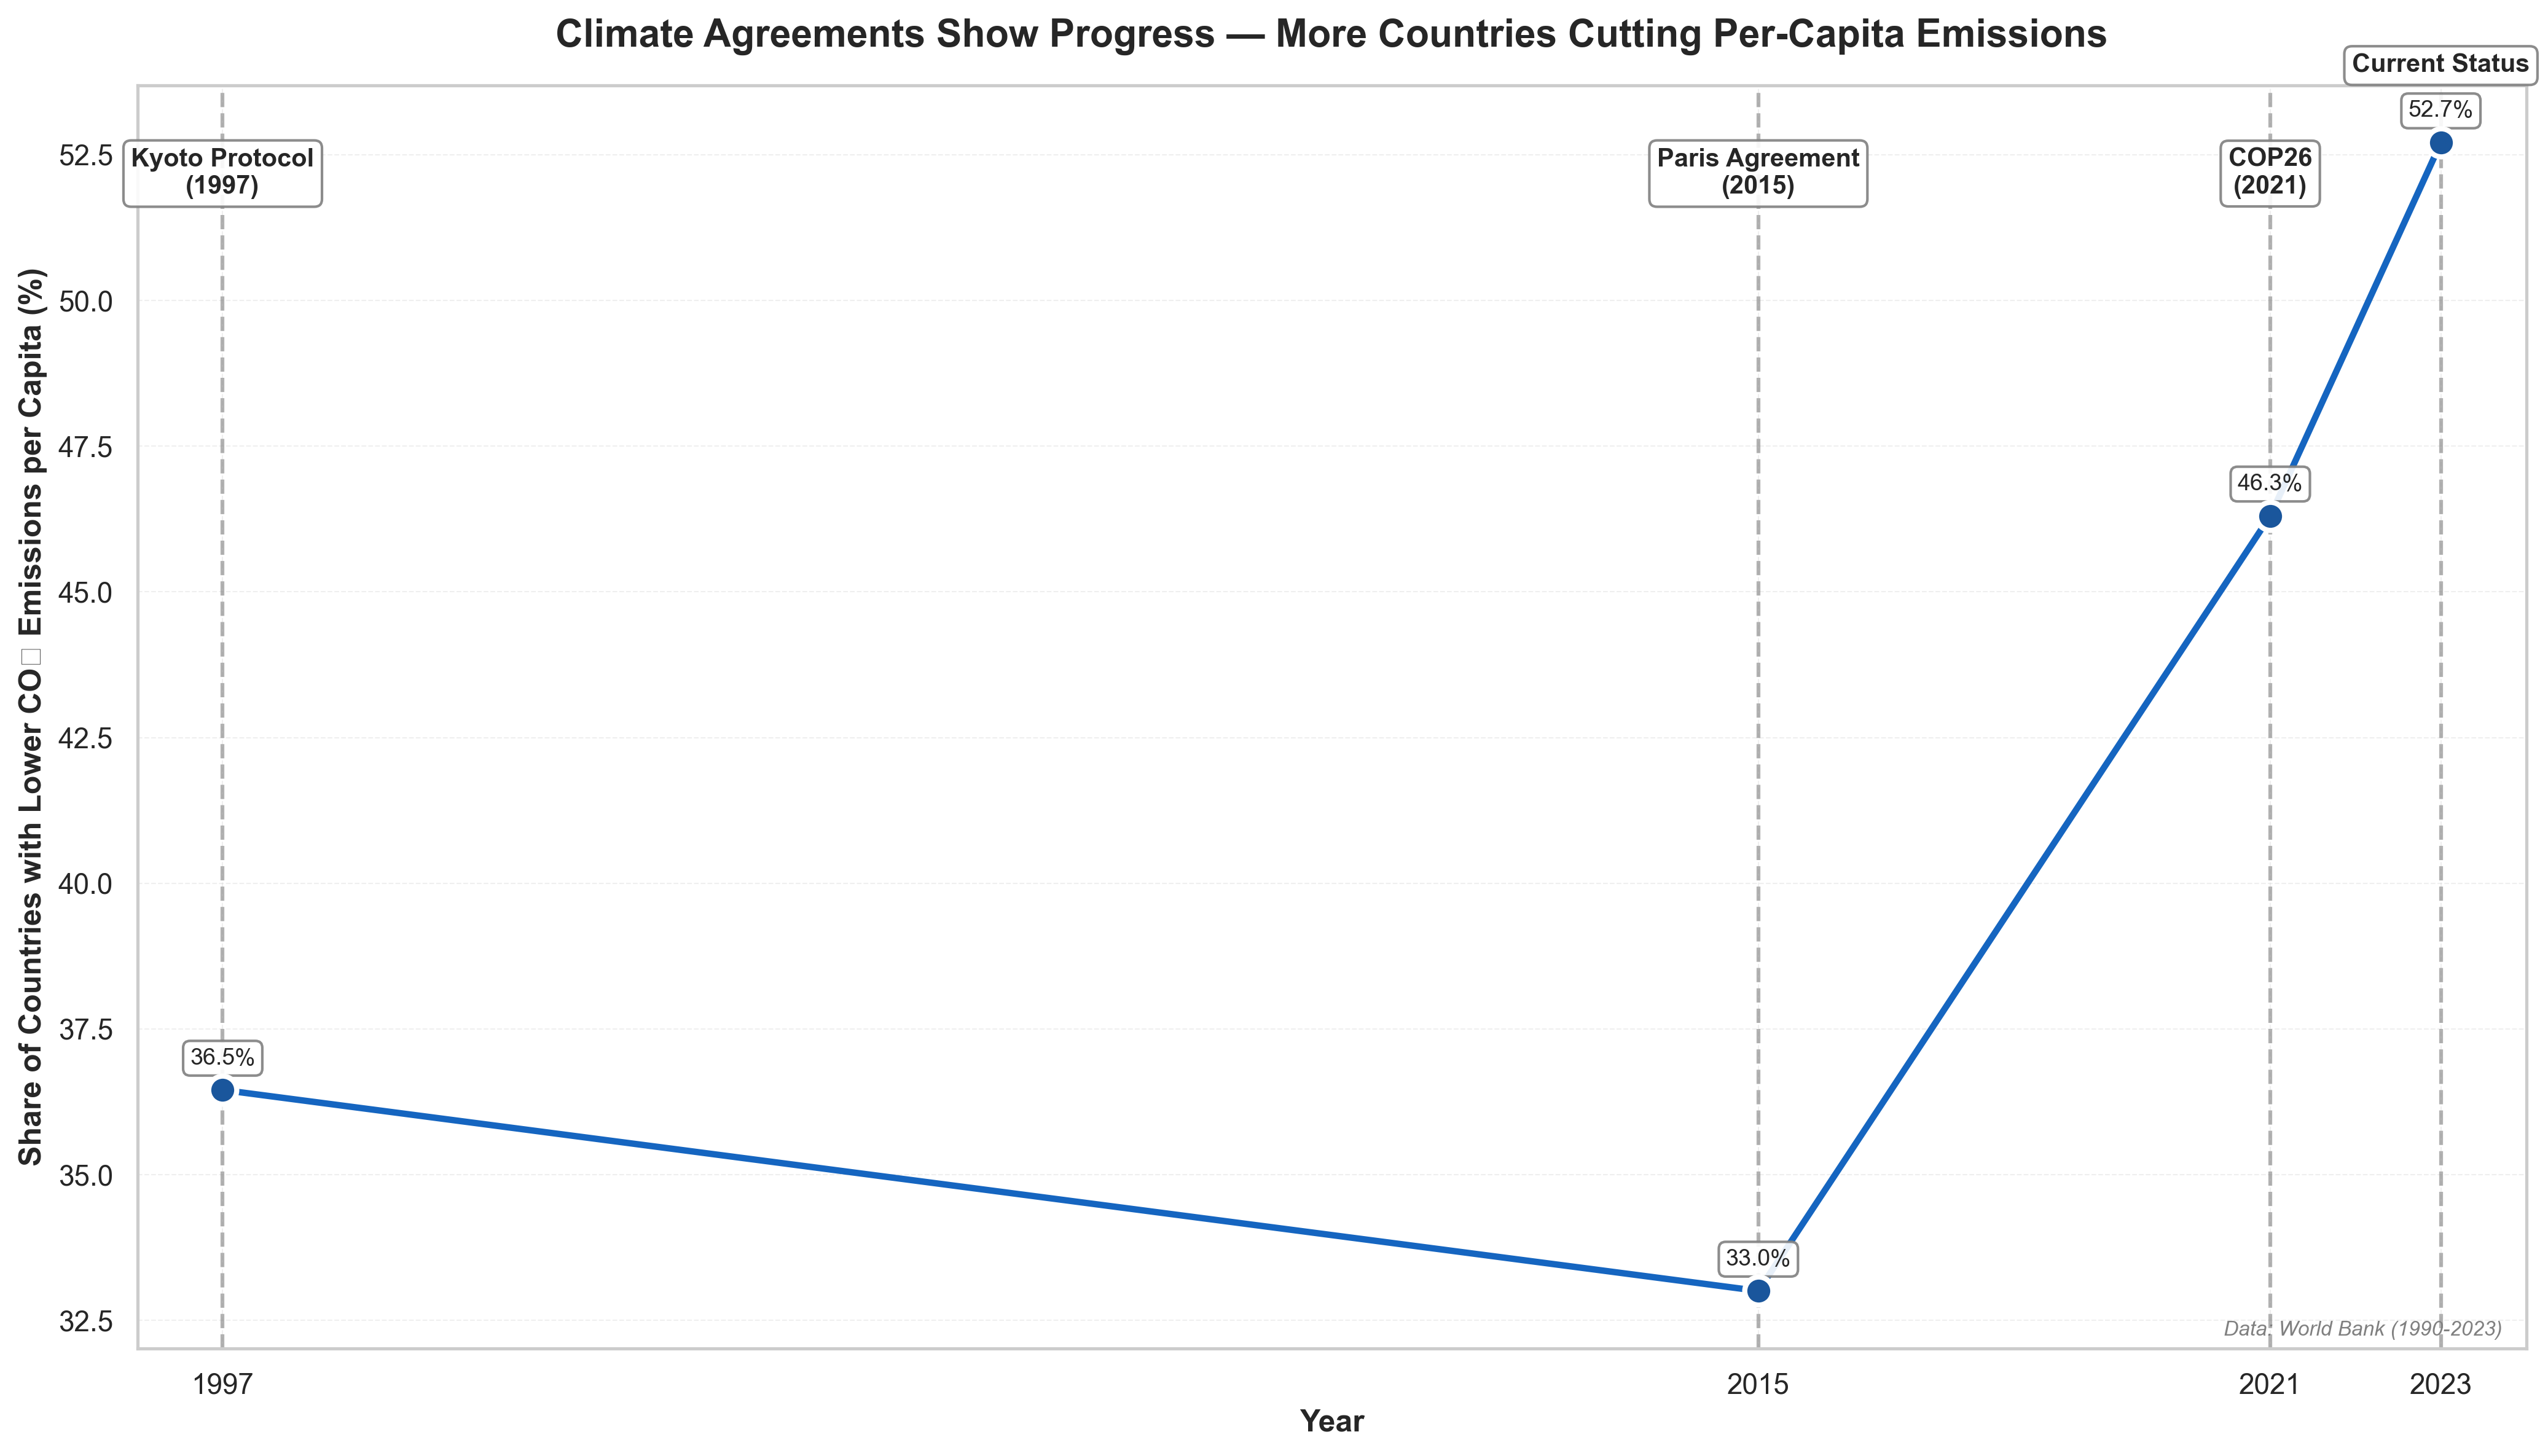

In [44]:
# VISUALIZATION 5: Climate Agreements and Per-Capita Emissions Progress

# Calculate statistics for each climate milestone
def calculate_reduction_stats(df, year_prev, year_curr):
    """
    Compare per-capita emissions between two years and identify:
    1. Percentage of countries that reduced emissions
    2. Top 5 countries with largest absolute reductions
    3. Worst 5 countries with largest increases
    """
    # Get data for both years
    prev = df[df['Year'] == year_prev][['Country Name', 'CO2_per_capita_kt']].rename(
        columns={'CO2_per_capita_kt': 'co2_prev'})
    curr = df[df['Year'] == year_curr][['Country Name', 'CO2_per_capita_kt']].rename(
        columns={'CO2_per_capita_kt': 'co2_curr'})
    
    # Merge and calculate absolute reduction
    comparison = prev.merge(curr, on='Country Name', how='inner').dropna()
    
    if len(comparison) == 0:
        return 0.0, 0, comparison, comparison
    
    comparison['reduction_abs'] = comparison['co2_prev'] - comparison['co2_curr']
    
    # Calculate percentage of countries that reduced emissions
    n_decreased = (comparison['reduction_abs'] > 0).sum()
    percent_decreased = (n_decreased / len(comparison)) * 100
    
    # Identify top 5 reducers and worst 5 increasers
    top5 = (comparison[comparison['reduction_abs'] > 0]
            .nlargest(5, 'reduction_abs'))
    worst5 = (comparison[comparison['reduction_abs'] < 0]
              .nsmallest(5, 'reduction_abs'))
    
    return percent_decreased, len(comparison), top5, worst5

# Define climate milestones to analyze
baseline_year = 1990
milestones = [
    (1997, "Kyoto Protocol"),
    (2015, "Paris Agreement"),
    (2021, "COP26"),
    (2023, "Current Status")
]

# Filter data for analysis period
viz6_data = merged[(merged['Year'] >= 1990) & (merged['Year'] <= 2023)].copy()

# Calculate statistics for each milestone
milestone_years = []
percent_reduced = []
sample_sizes = []

for idx, (year, name) in enumerate(milestones):
    # Compare to previous milestone (or baseline for first one)
    reference_year = baseline_year if idx == 0 else milestones[idx - 1][0]
    
    pct, n_countries, top5, worst5 = calculate_reduction_stats(viz6_data, reference_year, year)
    
    milestone_years.append(year)
    percent_reduced.append(pct)
    sample_sizes.append(n_countries)


# Create visualization
fig, ax = plt.subplots(figsize=(14, 8))

# Plot trend line with markers
ax.plot(milestone_years, percent_reduced, marker='o', linewidth=2.5, 
        color='#1565C0', zorder=3)
ax.scatter(milestone_years, percent_reduced, s=120, color='#1a569cff',
          edgecolors='white', linewidth=2, zorder=5)

# Annotate percentage values on each point
for x, y in zip(milestone_years, percent_reduced):
    ax.annotate(f"{y:.1f}%", xy=(x, y), xytext=(0, 10),
               textcoords='offset points', ha='center', fontsize=9,
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                        edgecolor='gray', alpha=0.9))

# Add vertical lines and labels for each milestone
for x, (year, name) in zip(milestone_years, milestones):
    ax.axvline(x=x, color='gray', linestyle='--', linewidth=1.5, alpha=0.6)
    
    y_pos = ax.get_ylim()[1] * (1.01 if name == "Current Status" else 0.98)
    label = name if name == "Current Status" else f"{name}\n({year})"
    
    ax.text(x, y_pos, label, ha='center', va='top', fontsize=10, fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                    edgecolor='gray', alpha=0.9))

# Format plot
ax.set_xlim(1996, 2024)
ax.set_xticks(milestone_years)
ax.set_xticklabels([str(y) for y in milestone_years], fontsize=11)
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Share of Countries with Lower CO₂ Emissions per Capita (%)',
              fontsize=12, fontweight='bold')
ax.set_title('Climate Agreements Show Progress — More Countries Cutting Per-Capita Emissions',
             fontsize=15, fontweight='bold', pad=15)


ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Add data source
ax.text(0.99, 0.01, 'Data: World Bank (1990-2023)', transform=ax.transAxes,
        fontsize=8, ha='right', style='italic', color='gray')

plt.tight_layout()
plt.show()

# VISUALIZATION 6

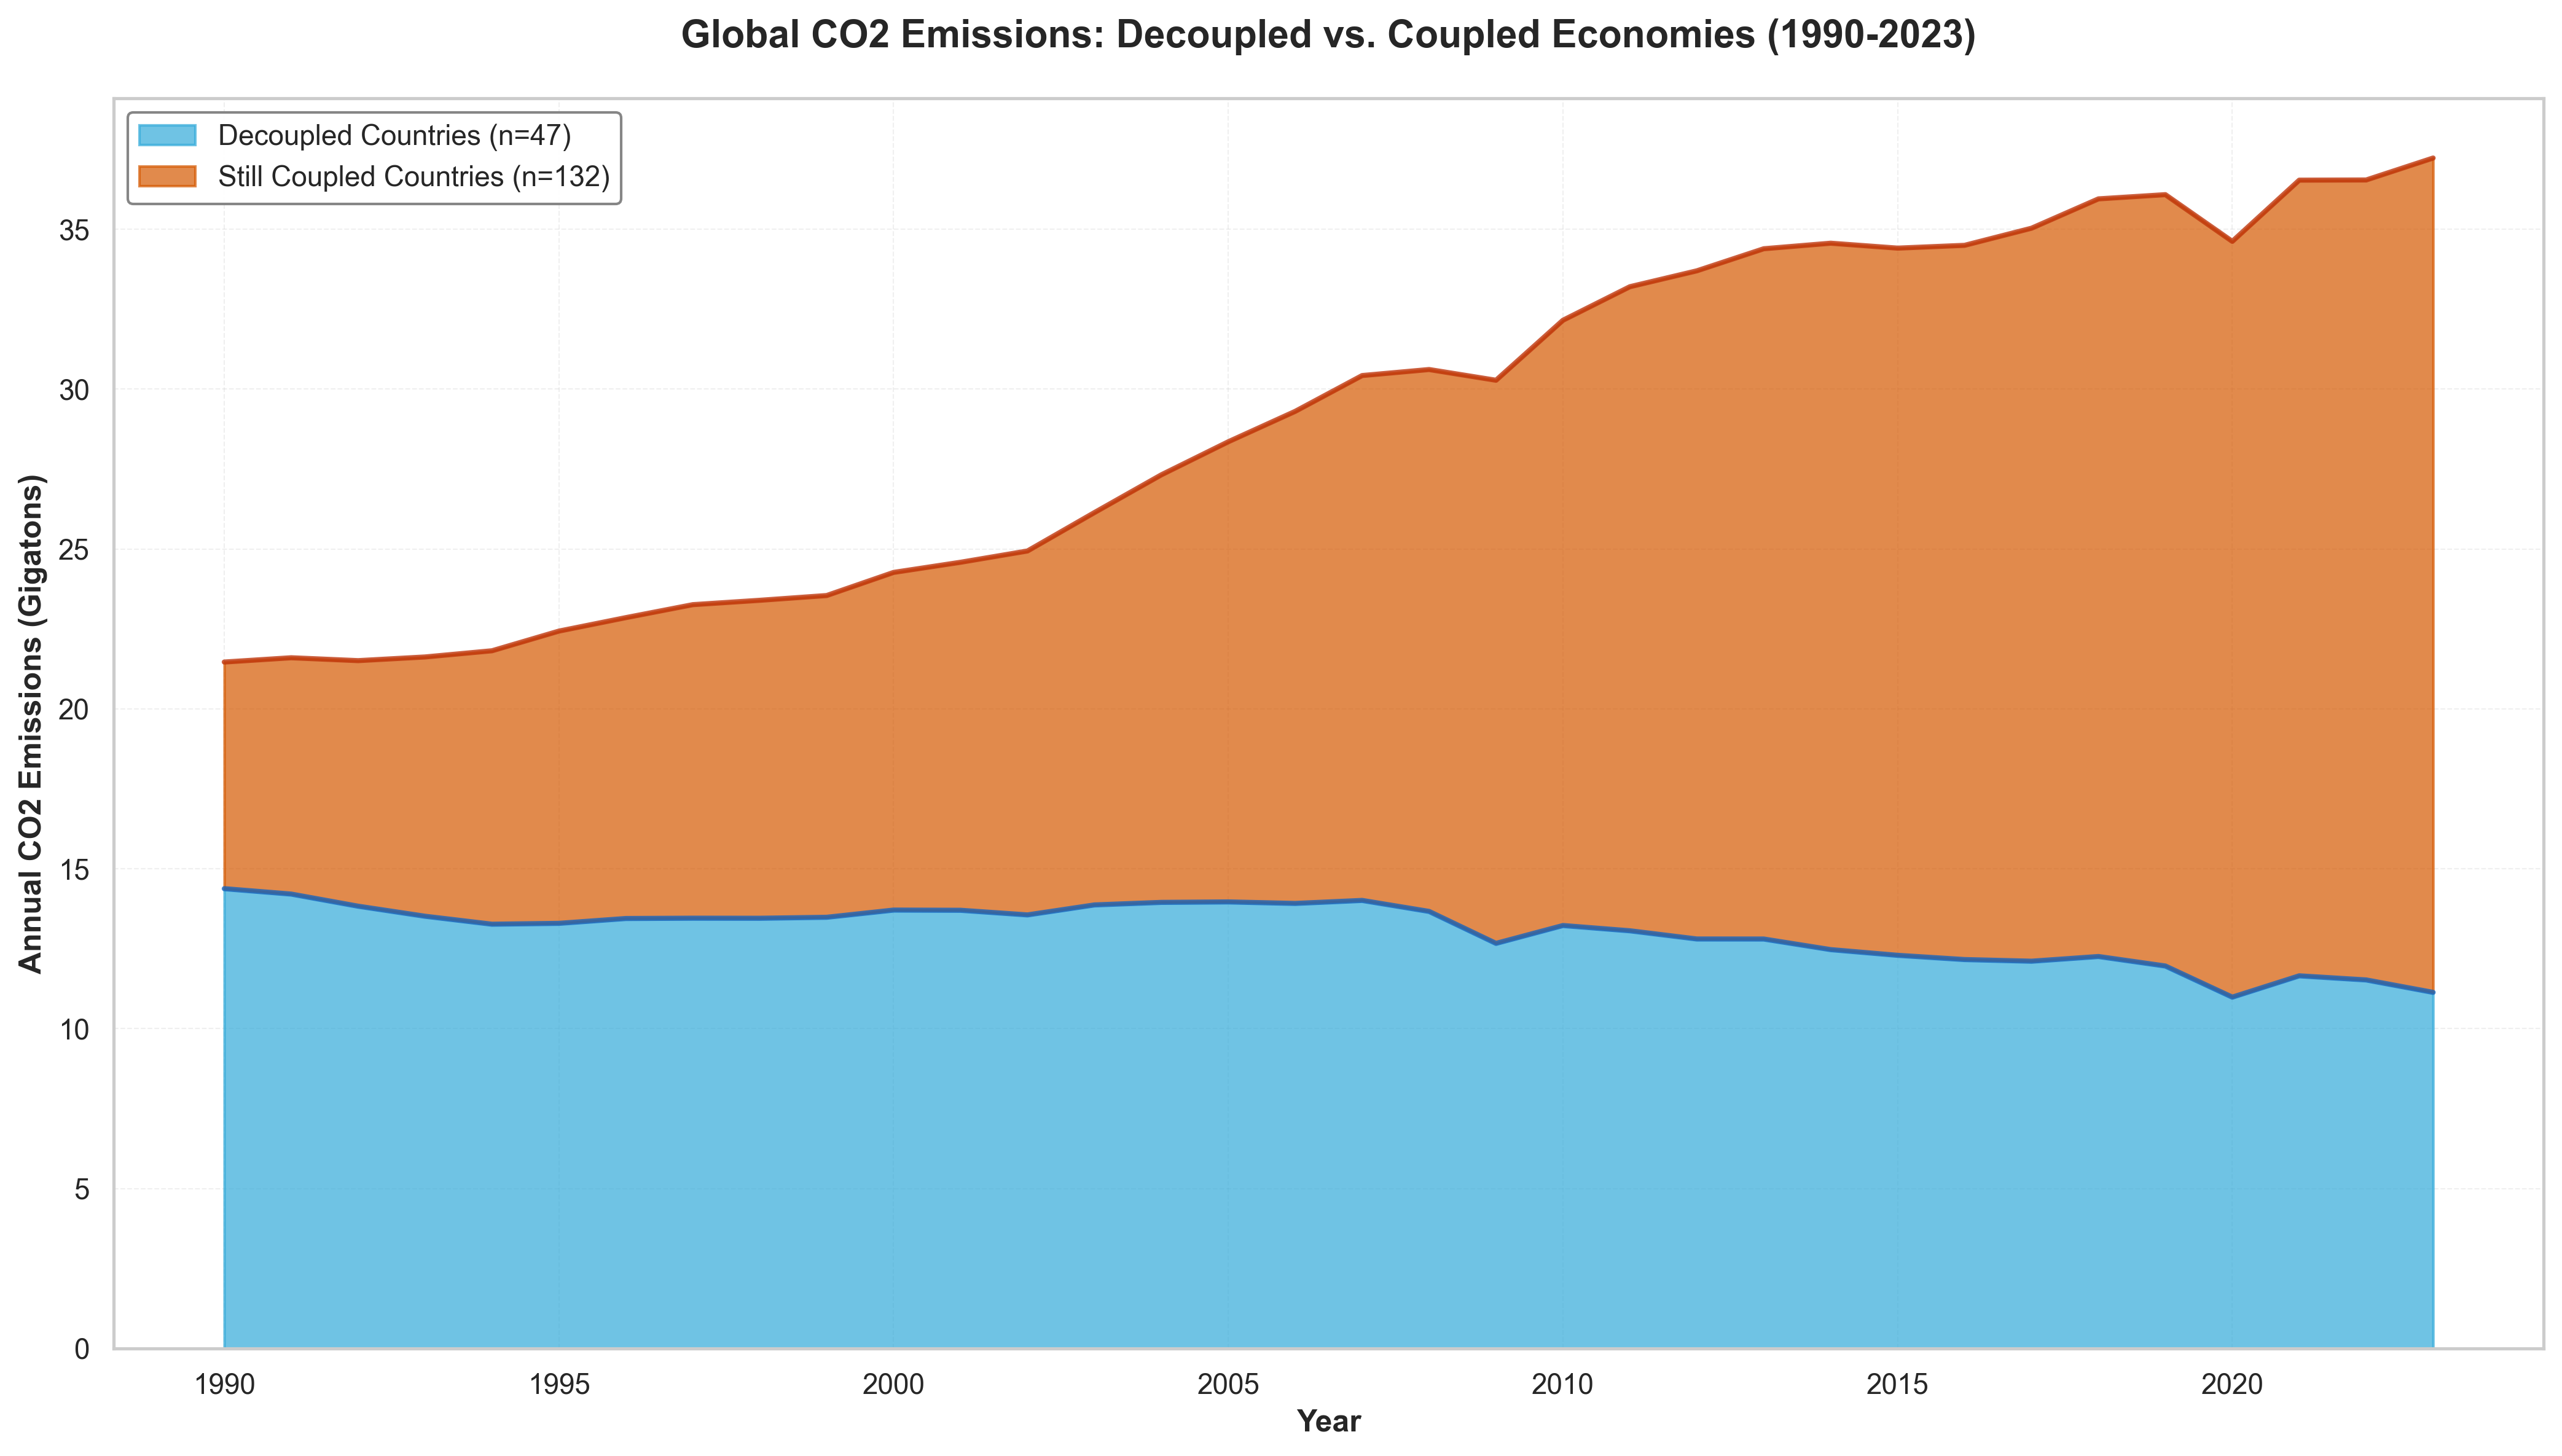

In [53]:
# VISUALIZATION 6: The Global Decoupling Divide (1990-2023)

# Classify all countries into decoupled vs. coupled categories
decoupled_countries = []
coupled_countries = []

for country in merged['Country Name'].unique():
    # Get 1990 and 2023 data for comparison
    country_data = merged[
        (merged['Country Name'] == country) & 
        (merged['Year'].isin([1990, 2023]))
    ].sort_values('Year')
    
    # Only classify countries with complete data for both years
    if len(country_data) == 2:
        gdp_1990, gdp_2023 = country_data['GDP'].values
        co2_1990, co2_2023 = country_data['CO2_emissions_kt'].values
        
        # Check for valid data (no NaN values)
        if pd.notna([gdp_1990, gdp_2023, co2_1990, co2_2023]).all():
            gdp_grew = gdp_2023 > gdp_1990
            co2_fell = co2_2023 < co2_1990
            
            # Decoupled: GDP increased while CO2 decreased
            if gdp_grew and co2_fell:
                decoupled_countries.append(country)
            # Coupled: GDP and CO2 both increased
            elif gdp_grew and co2_2023 > co2_1990:
                coupled_countries.append(country)

# Calculate total annual emissions for each group
viz5_data = merged[(merged['Year'] >= 1990) & (merged['Year'] <= 2023)].copy()
years = sorted(viz5_data['Year'].unique())

decoupled_emissions = []
coupled_emissions = []

for year in years:
    year_data = viz5_data[viz5_data['Year'] == year]
    
    # Sum emissions for each group, convert to gigatons
    # Dividing by 1000 to get the correct scale
    decoupled_total = year_data[year_data['Country Name'].isin(decoupled_countries)]['CO2_emissions_kt'].sum() / 1e3
    coupled_total = year_data[year_data['Country Name'].isin(coupled_countries)]['CO2_emissions_kt'].sum() / 1e3
    
    decoupled_emissions.append(decoupled_total)
    coupled_emissions.append(coupled_total)

# Calculate combined totals for top of stacked area
combined_emissions = [d + c for d, c in zip(decoupled_emissions, coupled_emissions)]

# Create visualization
fig, ax = plt.subplots(figsize=(14, 8))

# Stacked area chart using colors consistent with VIZ 2
ax.fill_between(years, 0, decoupled_emissions, 
                color='#32aad9ff', alpha=0.7,
                label=f'Decoupled Countries (n={len(decoupled_countries)})')

ax.fill_between(years, decoupled_emissions, combined_emissions,
                color='#d55800ff', alpha=0.7,
                label=f'Still Coupled Countries (n={len(coupled_countries)})')

# Add border lines for visual clarity
ax.plot(years, decoupled_emissions, color='#1565C0', linewidth=2, alpha=0.8)
ax.plot(years, combined_emissions, color='#BF360C', linewidth=2, alpha=0.8)

# Format plot
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Annual CO2 Emissions (Gigatons)', fontsize=12, fontweight='bold')
ax.set_title('Global CO2 Emissions: Decoupled vs. Coupled Economies (1990-2023)',
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper left', framealpha=0.95, edgecolor='gray')
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_ylim(bottom=0)  # Start at zero for honest comparison

plt.tight_layout()
plt.show()